In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle
import re


%reload_ext autoreload
%autoreload 2

In [76]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [77]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load and cut data from fits file, save as .json

In [78]:
data_json_fn = '../data/data_w_dith.json'
data_fits_fn = '../data/decam-exposures-20251211_w_dith.fits'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read(data_fits_fn)
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Get unique target fields given dithering

In [11]:
object_radec_df = df[['object', 'ra', 'dec']]

In [12]:
object_radec_groups = object_radec_df.groupby('object')

In [13]:
obj_name

NameError: name 'obj_name' is not defined

In [95]:
df.copy(deep=True)

,expnum,ra,dec,exptime,filter,propid,program,object,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff
0,229250,301.199042,-50.938332,90,g,2012B-0001,survey,DES survey hex -579-501 tiling 3,0.41,1.15,2013-08-31 23:55:07,139.5500,32.21,-33.208458,1.18,1.15,0.42,1.26,0.41
1,229251,300.851117,-52.967276,90,g,2012B-0001,survey,DES survey hex -582-521 tiling 3,0.60,1.18,2013-08-31 23:57:08,143.3200,32.76,-32.380917,1.19,1.18,0.15,1.23,0.60
2,229252,300.460079,-54.996221,90,g,2012B-0001,survey,DES survey hex -586-542 tiling 3,0.62,1.17,2013-08-31 23:59:08,146.9500,33.42,-31.494500,1.20,1.17,-0.07,1.22,0.62
3,229253,300.016742,-57.024887,90,g,2012B-0001,survey,DES survey hex -590-562 tiling 3,0.52,1.29,2013-09-01 00:01:11,150.4500,34.21,-30.536042,1.21,1.29,-0.21,1.20,0.52
4,229254,302.722079,-58.040193,90,g,2012B-0001,survey,DES survey hex -563-572 tiling 3,0.44,1.40,2013-09-01 00:03:13,150.5900,35.76,-32.738375,1.23,1.40,0.04,1.20,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88613,810366,58.930033,-42.303110,90,r,2012B-0001,des_celeb,NGC 1487,0.55,1.35,2019-01-10 04:27:33,238.7702,38.66,46.306458,1.28,1.35,0.09,-0.15,0.55
88614,810367,58.929917,-42.303138,90,i,2012B-0001,des_celeb,NGC 1487,0.51,1.16,2019-01-10 04:29:31,238.7969,39.02,46.803625,1.29,1.16,0.08,0.19,0.51
88615,810370,53.414579,-36.057110,45,i,2012B-0001,des_celeb,NGC 1365,0.30,1.41,2019-01-10 04:35:39,247.6877,44.83,53.840917,1.41,1.41,0.08,0.34,0.30
88616,810371,53.389708,-36.223610,45,g,2012B-0001,des_celeb,NGC 1365,0.46,1.59,2019-01-10 04:36:53,247.3923,45.09,54.204458,1.42,1.59,0.12,-0.18,0.46


In [21]:
df_filtered = df.copy(deep=True)
outlier_indices = []
for obj_name, g in object_radec_groups:
    # print(g.index)

    cutoff_deg = 3
    median_ra = g.ra.median()
    delta_ra = g.ra - median_ra
    delta_ra_shifted = np.remainder(delta_ra + 180, 360) - 180
    mask_outlier_ra = np.abs(delta_ra_shifted) > cutoff_deg

    median_dec = g.dec.median()
    delta_dec = g.dec - median_dec
    delta_dec_shifted = np.remainder(delta_dec + 180, 360) - 180
    mask_outlier_dec = np.abs(delta_dec_shifted) > cutoff_deg

    mask_outlier = mask_outlier_ra | mask_outlier_dec

    if np.count_nonzero(mask_outlier) > 0:
        indices = g.index[mask_outlier].values
        outlier_indices.extend(indices)
        

df_filtered.loc[outlier_indices, 'object'] = [f'{obj_name} (outlier)' for obj_name in df.loc[outlier_indices, 'object'].values]


In [15]:
df_filtered.loc[outlier_indices, 'object'].values

array(['DES survey hex -184-552 tiling 2 (outlier)',
       'DES survey hex -287-511 tiling 1 (outlier)',
       'DES survey hex -302-572 tiling 2 (outlier)',
       'DES survey hex 10-390 tiling 4 (outlier)',
       'DES survey hex 106-562 tiling 3 (outlier)',
       'DES survey hex 11-592 tiling 2 (outlier)',
       'DES survey hex 11-592 tiling 2 (outlier)',
       'DES survey hex 133-308 tiling 4 (outlier)',
       'DES survey hex 244-14 tiling 2 (outlier)',
       'DES survey hex 307+47 tiling 5 (outlier)',
       'DES survey hex 4+37 tiling 3 (outlier)',
       'DES survey hex 4-24 tiling 3 (outlier)',
       'DES survey hex 4-4 tiling 3 (outlier)',
       'DES survey hex 4-4 tiling 3 (outlier)',
       'DES survey hex 4-45 tiling 3 (outlier)',
       'DES survey hex 485-166 tiling 9 (outlier)',
       'DES survey hex 698-501 tiling 10 (outlier)',
       'DES survey hex 748-501 tiling 10 (outlier)',
       'DES survey hex 919-491 tiling 7 (outlier)',
       'DES survey hex 932-36

In [16]:
[f'{obj_name} (outlier)' for obj_name in df.loc[outlier_indices, 'object'].values]

['DES survey hex -184-552 tiling 2 (outlier)',
 'DES survey hex -287-511 tiling 1 (outlier)',
 'DES survey hex -302-572 tiling 2 (outlier)',
 'DES survey hex 10-390 tiling 4 (outlier)',
 'DES survey hex 106-562 tiling 3 (outlier)',
 'DES survey hex 11-592 tiling 2 (outlier)',
 'DES survey hex 11-592 tiling 2 (outlier)',
 'DES survey hex 133-308 tiling 4 (outlier)',
 'DES survey hex 244-14 tiling 2 (outlier)',
 'DES survey hex 307+47 tiling 5 (outlier)',
 'DES survey hex 4+37 tiling 3 (outlier)',
 'DES survey hex 4-24 tiling 3 (outlier)',
 'DES survey hex 4-4 tiling 3 (outlier)',
 'DES survey hex 4-4 tiling 3 (outlier)',
 'DES survey hex 4-45 tiling 3 (outlier)',
 'DES survey hex 485-166 tiling 9 (outlier)',
 'DES survey hex 698-501 tiling 10 (outlier)',
 'DES survey hex 748-501 tiling 10 (outlier)',
 'DES survey hex 919-491 tiling 7 (outlier)',
 'DES survey hex 932-369 tiling 3 (outlier)',
 'guided (outlier)']

In [17]:
np.count_nonzero(df_filtered.object.str.contains('outlier'))

np.int64(21)

In [ ]:
# df.loc[mask, 'base_object'] = df.loc[mask, 'object'].str.extract(pattern, expand=False)


In [18]:
df_filtered = df_filtered.drop(outlier_indices)

In [19]:
len(df_filtered)

88597

In [173]:
len(df) - len(df_filtered)

21

In [174]:
len(outlier_indices)

21

In [22]:
groups.get_group('DES survey hex 11-592 tiling 3')

NameError: name 'groups' is not defined

In [127]:
groups.object == 'DES survey hex 11-592 tiling 3'

False

In [23]:
df_dropped_outliers = df.drop('row2')

KeyError: "['row2'] not found in axis"

In [70]:
for g in object_radec_groups.groups:
    print(g.indices)
    break

AttributeError: 'str' object has no attribute 'indices'

In [51]:
groups = df.groupby('object')

In [63]:
groups.nth(1)

,expnum,ra,dec,exptime,filter,propid,program,object,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff
35,229286,301.198950,-50.937665,90,r,2012B-0001,survey,DES survey hex -579-501 tiling 3,0.51,1.11,2013-09-01 01:15:03,158.2900,22.94,-13.171250,1.09,1.11,0.15,3.69,0.51
42,229293,300.851371,-52.966582,90,r,2012B-0001,survey,DES survey hex -582-521 tiling 3,0.78,0.91,2013-09-01 01:31:05,166.6200,23.65,-8.818292,1.09,0.91,0.01,3.61,0.78
46,229297,306.056279,-52.966610,90,r,2012B-0001,survey,DES survey hex -530-521 tiling 3,0.82,0.90,2013-09-01 01:40:44,162.7900,24.28,-11.599083,1.10,0.90,-0.01,3.52,0.82
47,229298,303.324992,-53.981971,90,r,2012B-0001,survey,DES survey hex -558-532 tiling 3,0.71,0.97,2013-09-01 01:42:43,168.0200,24.53,-8.374167,1.10,0.97,0.00,3.50,0.71
50,229301,303.574200,-51.952471,90,r,2012B-0001,survey,DES survey hex -555-511 tiling 3,0.81,0.89,2013-09-01 01:48:45,168.3700,22.36,-7.101125,1.08,0.89,0.14,3.62,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88486,809774,43.826746,-66.882220,90,g,2012B-0001,survey,DES survey hex 458-674 tiling 2,0.64,1.39,2019-01-08 02:54:01,200.0261,42.48,36.086417,1.35,1.39,0.11,-0.24,0.64
88487,809775,63.086879,-66.932998,90,g,2012B-0001,survey,DES survey hex 611-674 tiling 9,0.88,1.20,2019-01-08 02:56:46,190.9898,38.20,17.590750,1.27,1.20,0.09,-0.28,0.88
88573,810322,41.159533,-66.476387,90,r,2012B-0001,survey,DES survey hex 418-663 tiling 8,0.85,1.03,2019-01-10 02:55:59,202.3400,43.85,41.238042,1.39,1.03,0.04,-0.03,0.85
88607,810357,58.954950,-42.284693,90,r,2012B-0001,des_celeb,NGC 1487,0.87,1.08,2019-01-10 04:14:01,238.5064,36.13,42.889208,1.24,1.08,0.09,-0.16,0.87


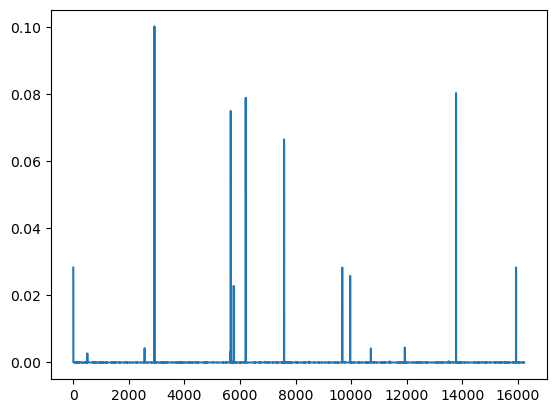

In [47]:
plt.plot(np.array(dith_areas)[np.array(dith_areas) < 1])

In [54]:
error_fields

['DES survey hex -302-572 tiling 2',
 'DES survey hex 106-562 tiling 3',
 'DES survey hex 4-24 tiling 3',
 'DES survey hex 748-501 tiling 10',
 'DES survey hex 10-390 tiling 4',
 'DES survey hex 485-166 tiling 9',
 'DES survey hex -184-552 tiling 2',
 'DES survey hex 4+37 tiling 3',
 'DES survey hex -287-511 tiling 1',
 'DES survey hex 11-592 tiling 2',
 'DES survey hex 698-501 tiling 10',
 'DES survey hex 133-308 tiling 4',
 'DES survey hex 4-45 tiling 3',
 'DES survey hex 919-491 tiling 7']

Check out fields which have very large dithering areas

In [55]:
mask = df['object'].isin(error_fields)

In [56]:
extracted_rows = df[mask]

In [57]:
one_tiling = extracted_rows[extracted_rows['object'].str.contains(error_fields[0])]

In [61]:
np.sort(one_tiling.ra)

array([328.396246, 328.396408, 328.396454, 328.396483, 328.396529,
       328.396529, 328.396575, 349.705033])

In [59]:
[(obj, ra, dec) for obj, ra, dec in zip(one_tiling.object, one_tiling.ra, one_tiling.dec)]

[('DES survey hex -302-572 tiling 2', 328.396408, -56.737859),
 ('DES survey hex -302-572 tiling 2', 328.396454, -56.737471),
 ('DES survey hex -302-572 tiling 2', 328.396483, -56.737471),
 ('DES survey hex -302-572 tiling 2', 328.396246, -56.737693),
 ('DES survey hex -302-572 tiling 2', 328.396575, -56.737582),
 ('DES survey hex -302-572 tiling 2', 349.705033, -46.592665),
 ('DES survey hex -302-572 tiling 2', 328.396529, -56.737526),
 ('DES survey hex -302-572 tiling 2', 328.396529, -56.737526)]

In [60]:
np.mean(one_tiling.ra)

np.float64(331.060032125)

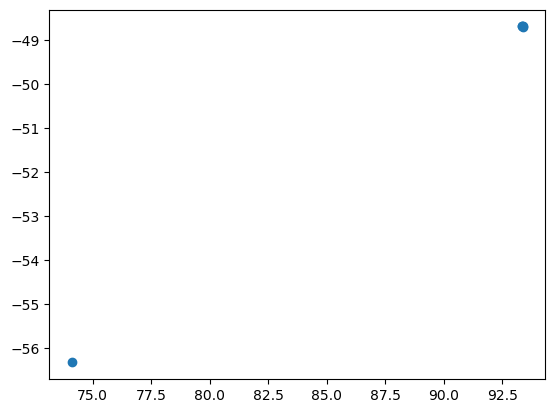

In [44]:
plt.scatter(one_tiling.ra, one_tiling.dec)

# Instantiate the offline dataset choosing binning method (healpix vs uniform_grid)

In [79]:
dataset = OfflineDECamDataset(
    df, 
    binning_method='healpix',
    nside=8,
    bin_space='azel',
    specific_years=[2014],
    # specific_months=[12],
    include_bin_features=False
)

ValueError: THETA is out of range [0,pi]

# Train

In [6]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [7]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 5,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'OfflineEnv'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': True,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Visualize dataset in az, el and ra, dec

In [13]:
obj_names, counts = np.unique(dataset._df.object, return_counts=True)

Text(0, 0.5, 'Number of fields')

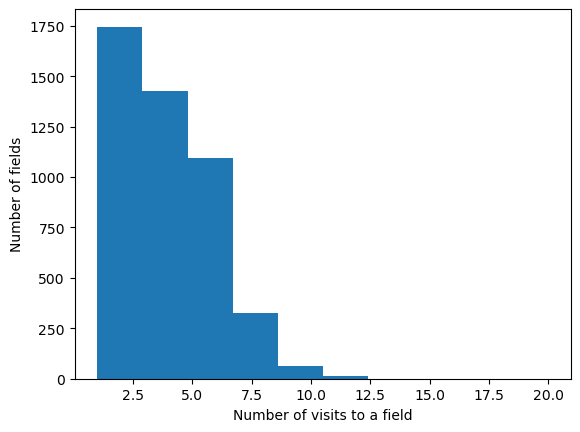

In [14]:
plt.hist(counts)
plt.xlabel('Number of visits to a field')
plt.ylabel('Number of fields')

Text(0.5, 0, 'Number of observations in a night')

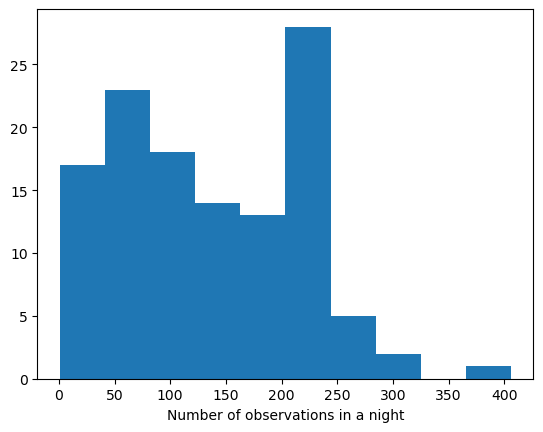

In [15]:
plt.hist(dataset.n_obs_per_night)
plt.xlabel('Number of observations in a night')

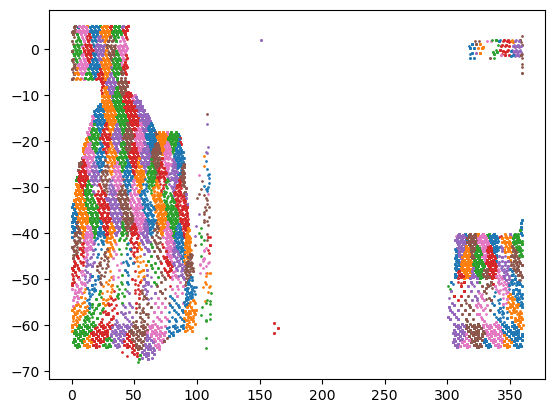

In [20]:
colors = [f'C{i}' for i in range(7)]
for i, (bin_id, g) in enumerate(dataset._df.groupby('bin')):
    plt.scatter(g.ra, g.dec, label=bin_id, color=colors[i%len(colors)], s=1)

# Train

In [8]:
# circle on gif is a 1.1deg radius --> maybe nside = 16 is enough, (nside=32 is about a 3 deg area)

In [9]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                                                  | 0/82735 [00:00<?, ?it/s]/home/rachel/Projects/survey-ops/survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/rachel/Projects/survey-ops/survey_ops/src/agents.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device)
  0%|                                                                        | 39/82735 [00:00<06:40, 206.39it/s]

Train step 0: Accuracy = 0.000, Loss = 6.6559, Q-val=0.000


  0%|▏                                                                      | 166/82735 [00:00<03:39, 375.98it/s]

Train step 100: Accuracy = 0.125, Loss = 4.0264, Q-val=0.000


  0%|▏                                                                      | 253/82735 [00:00<03:23, 405.14it/s]

Train step 200: Accuracy = 0.156, Loss = 2.4420, Q-val=0.000


  0%|▎                                                                      | 385/82735 [00:01<03:16, 418.57it/s]

Train step 300: Accuracy = 0.188, Loss = 2.4681, Q-val=0.000


  1%|▍                                                                      | 469/82735 [00:01<03:20, 410.57it/s]

Train step 400: Accuracy = 0.219, Loss = 2.5308, Q-val=0.000


  1%|▍                                                                      | 552/82735 [00:01<03:20, 409.57it/s]

Train step 500: Accuracy = 0.312, Loss = 2.4611, Q-val=0.000


  1%|▌                                                                      | 680/82735 [00:01<03:14, 422.10it/s]

Train step 600: Accuracy = 0.594, Loss = 2.1246, Q-val=0.000


  1%|▋                                                                      | 770/82735 [00:01<03:08, 435.12it/s]

Train step 700: Accuracy = 0.438, Loss = 2.4579, Q-val=0.000


  1%|▋                                                                      | 858/82735 [00:02<03:10, 430.61it/s]

Train step 800: Accuracy = 0.438, Loss = 2.2345, Q-val=0.000


  1%|▊                                                                      | 945/82735 [00:02<03:13, 423.49it/s]

Train step 900: Accuracy = 0.250, Loss = 1.8001, Q-val=0.000


  1%|▉                                                                     | 1078/82735 [00:02<03:07, 435.20it/s]

Train step 1000: Accuracy = 0.406, Loss = 1.7803, Q-val=0.000


  1%|▉                                                                     | 1169/82735 [00:02<03:05, 439.11it/s]

Train step 1100: Accuracy = 0.344, Loss = 2.5461, Q-val=0.000


  2%|█                                                                     | 1257/82735 [00:03<03:07, 435.26it/s]

Train step 1200: Accuracy = 0.406, Loss = 1.9842, Q-val=0.000


  2%|█▏                                                                    | 1345/82735 [00:03<03:09, 430.38it/s]

Train step 1300: Accuracy = 0.438, Loss = 1.8723, Q-val=0.000


  2%|█▏                                                                    | 1474/82735 [00:03<03:17, 410.52it/s]

Train step 1400: Accuracy = 0.562, Loss = 1.6227, Q-val=0.000


  2%|█▎                                                                    | 1557/82735 [00:03<03:20, 403.97it/s]

Train step 1500: Accuracy = 0.469, Loss = 2.1223, Q-val=0.000


  2%|█▍                                                                    | 1687/82735 [00:04<03:12, 421.69it/s]

Train step 1600: Accuracy = 0.531, Loss = 1.7127, Q-val=0.000


  2%|█▌                                                                    | 1775/82735 [00:04<03:08, 428.65it/s]

Train step 1700: Accuracy = 0.406, Loss = 1.6072, Q-val=0.000


  2%|█▌                                                                    | 1861/82735 [00:04<03:11, 422.53it/s]

Train step 1800: Accuracy = 0.750, Loss = 1.7780, Q-val=0.000


  2%|█▋                                                                    | 1946/82735 [00:04<03:16, 410.87it/s]

Train step 1900: Accuracy = 0.375, Loss = 1.4627, Q-val=0.000


  3%|█▊                                                                    | 2073/82735 [00:05<03:18, 407.07it/s]

Train step 2000: Accuracy = 0.406, Loss = 1.5340, Q-val=0.000


  3%|█▊                                                                    | 2156/82735 [00:05<03:20, 402.41it/s]

Train step 2100: Accuracy = 0.500, Loss = 1.1077, Q-val=0.000


  3%|█▉                                                                    | 2285/82735 [00:05<03:12, 418.41it/s]

Train step 2200: Accuracy = 0.438, Loss = 1.5336, Q-val=0.000


  3%|██                                                                    | 2372/82735 [00:05<03:09, 423.97it/s]

Train step 2300: Accuracy = 0.406, Loss = 1.6269, Q-val=0.000


  3%|██                                                                    | 2462/82735 [00:05<03:04, 435.42it/s]

Train step 2400: Accuracy = 0.406, Loss = 1.7756, Q-val=0.000


  3%|██▏                                                                   | 2548/82735 [00:06<03:30, 380.41it/s]

Train step 2500: Accuracy = 0.312, Loss = 1.7824, Q-val=0.000


  3%|██▏                                                                   | 2587/82735 [00:06<03:34, 373.48it/s]

Train step 2600: Accuracy = 0.375, Loss = 1.9110, Q-val=0.000


  3%|██▎                                                                   | 2744/82735 [00:06<03:26, 387.17it/s]

Train step 2700: Accuracy = 0.531, Loss = 1.5195, Q-val=0.000


  3%|██▍                                                                   | 2876/82735 [00:07<03:09, 422.26it/s]

Train step 2800: Accuracy = 0.625, Loss = 1.7218, Q-val=0.000


  4%|██▌                                                                   | 2962/82735 [00:07<03:16, 405.76it/s]

Train step 2900: Accuracy = 0.344, Loss = 1.9583, Q-val=0.000


  4%|██▌                                                                   | 3042/82735 [00:07<03:52, 342.85it/s]

Train step 3000: Accuracy = 0.656, Loss = 2.2776, Q-val=0.000


  4%|██▋                                                                   | 3167/82735 [00:07<03:25, 386.30it/s]

Train step 3100: Accuracy = 0.406, Loss = 1.5048, Q-val=0.000


  4%|██▊                                                                   | 3255/82735 [00:08<03:14, 409.65it/s]

Train step 3200: Accuracy = 0.406, Loss = 1.5195, Q-val=0.000


  4%|██▊                                                                   | 3379/82735 [00:08<03:17, 401.84it/s]

Train step 3300: Accuracy = 0.500, Loss = 1.6584, Q-val=0.000


  4%|██▉                                                                   | 3462/82735 [00:08<03:18, 398.79it/s]

Train step 3400: Accuracy = 0.562, Loss = 1.6457, Q-val=0.000


  4%|███                                                                   | 3546/82735 [00:08<03:14, 407.82it/s]

Train step 3500: Accuracy = 0.625, Loss = 1.3635, Q-val=0.000


  4%|███                                                                   | 3673/82735 [00:09<03:09, 416.78it/s]

Train step 3600: Accuracy = 0.344, Loss = 1.3396, Q-val=0.000


  5%|███▏                                                                  | 3763/82735 [00:09<03:02, 432.93it/s]

Train step 3700: Accuracy = 0.469, Loss = 2.0612, Q-val=0.000


  5%|███▎                                                                  | 3851/82735 [00:09<03:02, 431.81it/s]

Train step 3800: Accuracy = 0.594, Loss = 1.5205, Q-val=0.000


  5%|███▎                                                                  | 3984/82735 [00:09<03:03, 428.73it/s]

Train step 3900: Accuracy = 0.562, Loss = 1.4077, Q-val=0.000


  5%|███▍                                                                  | 4072/82735 [00:10<03:03, 429.47it/s]

Train step 4000: Accuracy = 0.562, Loss = 1.6631, Q-val=0.000


  5%|███▌                                                                  | 4158/82735 [00:10<03:05, 423.53it/s]

Train step 4100: Accuracy = 0.500, Loss = 1.2769, Q-val=0.000


  5%|███▌                                                                  | 4244/82735 [00:10<03:07, 418.71it/s]

Train step 4200: Accuracy = 0.500, Loss = 1.5784, Q-val=0.000


  5%|███▋                                                                  | 4375/82735 [00:10<03:05, 421.51it/s]

Train step 4300: Accuracy = 0.594, Loss = 1.5798, Q-val=0.000


  5%|███▊                                                                  | 4461/82735 [00:10<03:09, 413.59it/s]

Train step 4400: Accuracy = 0.500, Loss = 1.6184, Q-val=0.000


  5%|███▊                                                                  | 4548/82735 [00:11<03:05, 421.71it/s]

Train step 4500: Accuracy = 0.625, Loss = 1.5028, Q-val=0.000


  6%|███▉                                                                  | 4678/82735 [00:11<03:04, 423.71it/s]

Train step 4600: Accuracy = 0.531, Loss = 1.2686, Q-val=0.000


  6%|████                                                                  | 4763/82735 [00:11<03:07, 416.27it/s]

Train step 4700: Accuracy = 0.531, Loss = 1.8524, Q-val=0.000


  6%|████                                                                  | 4850/82735 [00:11<03:04, 422.62it/s]

Train step 4800: Accuracy = 0.531, Loss = 1.3938, Q-val=0.000


  6%|████▏                                                                 | 4984/82735 [00:12<02:57, 438.36it/s]

Train step 4900: Accuracy = 0.406, Loss = 1.2755, Q-val=0.000


  6%|████▎                                                                 | 5075/82735 [00:12<02:55, 442.02it/s]

Train step 5000: Accuracy = 0.500, Loss = 1.4916, Q-val=0.000


  6%|████▎                                                                 | 5165/82735 [00:12<03:02, 424.19it/s]

Train step 5100: Accuracy = 0.594, Loss = 1.5861, Q-val=0.000


  6%|████▍                                                                 | 5208/82735 [00:12<03:18, 391.41it/s]

Train step 5200: Accuracy = 0.406, Loss = 1.3733, Q-val=0.000


  6%|████▌                                                                 | 5363/82735 [00:13<03:27, 372.35it/s]

Train step 5300: Accuracy = 0.469, Loss = 1.6881, Q-val=0.000


  7%|████▌                                                                 | 5442/82735 [00:13<03:23, 380.32it/s]

Train step 5400: Accuracy = 0.469, Loss = 1.3379, Q-val=0.000


  7%|████▋                                                                 | 5558/82735 [00:13<03:24, 378.30it/s]

Train step 5500: Accuracy = 0.531, Loss = 1.6481, Q-val=0.000


  7%|████▊                                                                 | 5673/82735 [00:13<03:26, 374.05it/s]

Train step 5600: Accuracy = 0.469, Loss = 1.1627, Q-val=0.000


  7%|████▊                                                                 | 5753/82735 [00:14<03:19, 385.83it/s]

Train step 5700: Accuracy = 0.500, Loss = 1.2818, Q-val=0.000


  7%|████▉                                                                 | 5874/82735 [00:14<03:15, 393.07it/s]

Train step 5800: Accuracy = 0.594, Loss = 1.6367, Q-val=0.000


  7%|█████                                                                 | 5953/82735 [00:14<03:20, 382.47it/s]

Train step 5900: Accuracy = 0.688, Loss = 1.4948, Q-val=0.000


  7%|█████▏                                                                | 6078/82735 [00:14<03:09, 404.08it/s]

Train step 6000: Accuracy = 0.656, Loss = 1.2898, Q-val=0.000


  7%|█████▏                                                                | 6160/82735 [00:15<03:14, 393.38it/s]

Train step 6100: Accuracy = 0.250, Loss = 1.1134, Q-val=0.000


  8%|█████▎                                                                | 6239/82735 [00:15<03:20, 381.23it/s]

Train step 6200: Accuracy = 0.625, Loss = 1.5337, Q-val=0.000


  8%|█████▍                                                                | 6363/82735 [00:15<03:10, 401.53it/s]

Train step 6300: Accuracy = 0.375, Loss = 1.4046, Q-val=0.000


  8%|█████▍                                                                | 6449/82735 [00:15<03:05, 412.15it/s]

Train step 6400: Accuracy = 0.688, Loss = 1.7961, Q-val=0.000


  8%|█████▌                                                                | 6577/82735 [00:16<03:02, 417.30it/s]

Train step 6500: Accuracy = 0.438, Loss = 1.7998, Q-val=0.000


  8%|█████▋                                                                | 6663/82735 [00:16<03:02, 415.80it/s]

Train step 6600: Accuracy = 0.594, Loss = 1.9168, Q-val=0.000


  8%|█████▋                                                                | 6749/82735 [00:16<03:01, 417.82it/s]

Train step 6700: Accuracy = 0.531, Loss = 1.3877, Q-val=0.000


  8%|█████▊                                                                | 6874/82735 [00:16<03:11, 396.31it/s]

Train step 6800: Accuracy = 0.531, Loss = 1.3111, Q-val=0.000


  8%|█████▉                                                                | 6955/82735 [00:17<03:13, 392.04it/s]

Train step 6900: Accuracy = 0.438, Loss = 1.1948, Q-val=0.000


  9%|█████▉                                                                | 7076/82735 [00:17<03:15, 386.51it/s]

Train step 7000: Accuracy = 0.531, Loss = 1.2255, Q-val=0.000


  9%|██████                                                                | 7158/82735 [00:17<03:10, 396.95it/s]

Train step 7100: Accuracy = 0.594, Loss = 1.4473, Q-val=0.000


  9%|██████▏                                                               | 7279/82735 [00:17<03:08, 400.06it/s]

Train step 7200: Accuracy = 0.656, Loss = 1.4101, Q-val=0.000


  9%|██████▏                                                               | 7361/82735 [00:18<03:07, 401.73it/s]

Train step 7300: Accuracy = 0.531, Loss = 1.3469, Q-val=0.000


  9%|██████▎                                                               | 7443/82735 [00:18<03:08, 399.56it/s]

Train step 7400: Accuracy = 0.594, Loss = 1.4341, Q-val=0.000


  9%|██████▍                                                               | 7562/82735 [00:18<03:14, 385.86it/s]

Train step 7500: Accuracy = 0.531, Loss = 1.6307, Q-val=0.000


  9%|██████▍                                                               | 7642/82735 [00:18<03:12, 390.36it/s]

Train step 7600: Accuracy = 0.438, Loss = 1.2698, Q-val=0.000


  9%|██████▌                                                               | 7770/82735 [00:19<03:02, 410.73it/s]

Train step 7700: Accuracy = 0.594, Loss = 1.1641, Q-val=0.000


  9%|██████▋                                                               | 7854/82735 [00:19<03:03, 407.85it/s]

Train step 7800: Accuracy = 0.594, Loss = 1.2904, Q-val=0.000


 10%|██████▊                                                               | 7980/82735 [00:19<03:01, 412.12it/s]

Train step 7900: Accuracy = 0.719, Loss = 1.3317, Q-val=0.000


 10%|██████▊                                                               | 8064/82735 [00:19<03:03, 407.22it/s]

Train step 8000: Accuracy = 0.562, Loss = 1.5145, Q-val=0.000


 10%|██████▉                                                               | 8147/82735 [00:20<03:02, 407.59it/s]

Train step 8100: Accuracy = 0.375, Loss = 1.5812, Q-val=0.000


 10%|███████                                                               | 8276/82735 [00:20<03:00, 413.00it/s]

Train step 8200: Accuracy = 0.531, Loss = 1.4833, Q-val=0.000


 10%|███████                                                               | 8360/82735 [00:20<03:02, 408.16it/s]

Train step 8300: Accuracy = 0.531, Loss = 1.3512, Q-val=0.000


 10%|███████▏                                                              | 8443/82735 [00:20<03:01, 408.52it/s]

Train step 8400: Accuracy = 0.719, Loss = 1.3815, Q-val=0.000


 10%|███████▏                                                              | 8566/82735 [00:21<03:04, 401.94it/s]

Train step 8500: Accuracy = 0.531, Loss = 1.5603, Q-val=0.000


 10%|███████▎                                                              | 8648/82735 [00:21<03:05, 399.18it/s]

Train step 8600: Accuracy = 0.688, Loss = 1.8565, Q-val=0.000


 11%|███████▍                                                              | 8775/82735 [00:21<02:58, 413.58it/s]

Train step 8700: Accuracy = 0.562, Loss = 1.3214, Q-val=0.000


 11%|███████▍                                                              | 8861/82735 [00:21<02:56, 417.52it/s]

Train step 8800: Accuracy = 0.594, Loss = 1.2306, Q-val=0.000


 11%|███████▌                                                              | 8944/82735 [00:22<03:02, 403.32it/s]

Train step 8900: Accuracy = 0.469, Loss = 1.9299, Q-val=0.000


 11%|███████▋                                                              | 9068/82735 [00:22<03:02, 403.01it/s]

Train step 9000: Accuracy = 0.688, Loss = 1.0270, Q-val=0.000


 11%|███████▋                                                              | 9152/82735 [00:22<03:00, 408.48it/s]

Train step 9100: Accuracy = 0.719, Loss = 1.3502, Q-val=0.000


 11%|███████▊                                                              | 9277/82735 [00:22<03:02, 403.51it/s]

Train step 9200: Accuracy = 0.625, Loss = 1.2874, Q-val=0.000


 11%|███████▉                                                              | 9358/82735 [00:23<03:04, 397.62it/s]

Train step 9300: Accuracy = 0.594, Loss = 0.9170, Q-val=0.000


 11%|████████                                                              | 9480/82735 [00:23<03:02, 402.42it/s]

Train step 9400: Accuracy = 0.594, Loss = 1.2867, Q-val=0.000


 12%|████████                                                              | 9564/82735 [00:23<03:00, 404.38it/s]

Train step 9500: Accuracy = 0.562, Loss = 1.5200, Q-val=0.000


 12%|████████▏                                                             | 9646/82735 [00:23<03:02, 400.63it/s]

Train step 9600: Accuracy = 0.625, Loss = 1.3686, Q-val=0.000


 12%|████████▎                                                             | 9770/82735 [00:24<03:02, 400.62it/s]

Train step 9700: Accuracy = 0.594, Loss = 1.3770, Q-val=0.000


 12%|████████▎                                                             | 9852/82735 [00:24<03:03, 396.81it/s]

Train step 9800: Accuracy = 0.531, Loss = 1.2115, Q-val=0.000


 12%|████████▍                                                             | 9972/82735 [00:24<03:06, 389.84it/s]

Train step 9900: Accuracy = 0.625, Loss = 1.5698, Q-val=0.000


 12%|████████▍                                                            | 10051/82735 [00:24<03:08, 386.53it/s]

Train step 10000: Accuracy = 0.656, Loss = 1.5002, Q-val=0.000


 12%|████████▍                                                            | 10176/82735 [00:25<03:00, 400.95it/s]

Train step 10100: Accuracy = 0.625, Loss = 1.1748, Q-val=0.000


 12%|████████▌                                                            | 10258/82735 [00:25<03:03, 395.17it/s]

Train step 10200: Accuracy = 0.594, Loss = 1.0668, Q-val=0.000


 13%|████████▋                                                            | 10382/82735 [00:25<02:57, 406.67it/s]

Train step 10300: Accuracy = 0.531, Loss = 1.3786, Q-val=0.000


 13%|████████▋                                                            | 10465/82735 [00:25<02:57, 406.62it/s]

Train step 10400: Accuracy = 0.531, Loss = 1.4206, Q-val=0.000


 13%|████████▊                                                            | 10547/82735 [00:26<02:58, 403.88it/s]

Train step 10500: Accuracy = 0.594, Loss = 1.0747, Q-val=0.000


 13%|████████▉                                                            | 10670/82735 [00:26<03:00, 400.33it/s]

Train step 10600: Accuracy = 0.531, Loss = 1.2320, Q-val=0.000


 13%|████████▉                                                            | 10751/82735 [00:26<03:00, 397.79it/s]

Train step 10700: Accuracy = 0.688, Loss = 1.2603, Q-val=0.000


 13%|█████████                                                            | 10874/82735 [00:26<03:00, 398.30it/s]

Train step 10800: Accuracy = 0.531, Loss = 1.1794, Q-val=0.000


 13%|█████████▏                                                           | 10957/82735 [00:27<02:58, 401.73it/s]

Train step 10900: Accuracy = 0.656, Loss = 1.3735, Q-val=0.000


 13%|█████████▏                                                           | 11083/82735 [00:27<02:53, 411.86it/s]

Train step 11000: Accuracy = 0.625, Loss = 1.6205, Q-val=0.000


 13%|█████████▎                                                           | 11167/82735 [00:27<03:01, 394.31it/s]

Train step 11100: Accuracy = 0.625, Loss = 1.8817, Q-val=0.000


 14%|█████████▍                                                           | 11249/82735 [00:27<03:00, 396.21it/s]

Train step 11200: Accuracy = 0.562, Loss = 1.0271, Q-val=0.000


 14%|█████████▍                                                           | 11373/82735 [00:28<02:56, 404.24it/s]

Train step 11300: Accuracy = 0.625, Loss = 1.5081, Q-val=0.000


 14%|█████████▌                                                           | 11455/82735 [00:28<02:56, 403.85it/s]

Train step 11400: Accuracy = 0.469, Loss = 1.4080, Q-val=0.000


 14%|█████████▋                                                           | 11579/82735 [00:28<02:57, 401.62it/s]

Train step 11500: Accuracy = 0.531, Loss = 1.5472, Q-val=0.000


 14%|█████████▋                                                           | 11666/82735 [00:28<02:51, 414.17it/s]

Train step 11600: Accuracy = 0.438, Loss = 1.2476, Q-val=0.000


 14%|█████████▊                                                           | 11752/82735 [00:29<02:49, 419.86it/s]

Train step 11700: Accuracy = 0.562, Loss = 1.3290, Q-val=0.000


 14%|█████████▉                                                           | 11878/82735 [00:29<02:56, 401.78it/s]

Train step 11800: Accuracy = 0.719, Loss = 1.3978, Q-val=0.000


 14%|█████████▉                                                           | 11960/82735 [00:29<02:55, 403.16it/s]

Train step 11900: Accuracy = 0.656, Loss = 1.4161, Q-val=0.000


 15%|██████████                                                           | 12043/82735 [00:29<02:53, 407.37it/s]

Train step 12000: Accuracy = 0.719, Loss = 1.5613, Q-val=0.000


 15%|██████████▏                                                          | 12167/82735 [00:30<02:55, 401.35it/s]

Train step 12100: Accuracy = 0.281, Loss = 1.0800, Q-val=0.000


 15%|██████████▏                                                          | 12249/82735 [00:30<02:57, 397.53it/s]

Train step 12200: Accuracy = 0.562, Loss = 1.0072, Q-val=0.000


 15%|██████████▎                                                          | 12376/82735 [00:30<02:50, 411.96it/s]

Train step 12300: Accuracy = 0.469, Loss = 1.5004, Q-val=0.000


 15%|██████████▍                                                          | 12461/82735 [00:30<02:48, 417.32it/s]

Train step 12400: Accuracy = 0.469, Loss = 1.3253, Q-val=0.000


 15%|██████████▍                                                          | 12545/82735 [00:31<02:49, 413.07it/s]

Train step 12500: Accuracy = 0.562, Loss = 1.4706, Q-val=0.000


 15%|██████████▌                                                          | 12671/82735 [00:31<02:50, 411.39it/s]

Train step 12600: Accuracy = 0.469, Loss = 1.7043, Q-val=0.000


 15%|██████████▋                                                          | 12755/82735 [00:31<02:50, 411.36it/s]

Train step 12700: Accuracy = 0.531, Loss = 1.1737, Q-val=0.000


 16%|██████████▋                                                          | 12882/82735 [00:31<02:48, 413.82it/s]

Train step 12800: Accuracy = 0.406, Loss = 1.3222, Q-val=0.000


 16%|██████████▊                                                          | 12965/82735 [00:32<02:54, 398.78it/s]

Train step 12900: Accuracy = 0.625, Loss = 1.0213, Q-val=0.000


 16%|██████████▉                                                          | 13050/82735 [00:32<02:50, 409.41it/s]

Train step 13000: Accuracy = 0.594, Loss = 1.0933, Q-val=0.000


 16%|██████████▉                                                          | 13176/82735 [00:32<02:47, 414.05it/s]

Train step 13100: Accuracy = 0.594, Loss = 1.0708, Q-val=0.000


 16%|███████████                                                          | 13259/82735 [00:32<02:52, 401.78it/s]

Train step 13200: Accuracy = 0.719, Loss = 1.5488, Q-val=0.000


 16%|███████████▏                                                         | 13342/82735 [00:33<02:53, 401.10it/s]

Train step 13300: Accuracy = 0.562, Loss = 0.9063, Q-val=0.000


 16%|███████████▏                                                         | 13463/82735 [00:33<02:58, 387.51it/s]

Train step 13400: Accuracy = 0.500, Loss = 1.4469, Q-val=0.000


 16%|███████████▎                                                         | 13543/82735 [00:33<02:57, 389.32it/s]

Train step 13500: Accuracy = 0.500, Loss = 1.5496, Q-val=0.000


 17%|███████████▍                                                         | 13664/82735 [00:33<02:58, 387.59it/s]

Train step 13600: Accuracy = 0.500, Loss = 1.6175, Q-val=0.000


 17%|███████████▍                                                         | 13746/82735 [00:34<02:54, 395.43it/s]

Train step 13700: Accuracy = 0.688, Loss = 1.6369, Q-val=0.000


 17%|███████████▌                                                         | 13872/82735 [00:34<02:47, 411.55it/s]

Train step 13800: Accuracy = 0.531, Loss = 1.3663, Q-val=0.000


 17%|███████████▋                                                         | 13956/82735 [00:34<02:49, 404.99it/s]

Train step 13900: Accuracy = 0.469, Loss = 1.0587, Q-val=0.000


 17%|███████████▋                                                         | 14080/82735 [00:34<02:51, 401.15it/s]

Train step 14000: Accuracy = 0.562, Loss = 1.4204, Q-val=0.000


 17%|███████████▊                                                         | 14161/82735 [00:35<02:52, 397.48it/s]

Train step 14100: Accuracy = 0.531, Loss = 1.0709, Q-val=0.000


 17%|███████████▉                                                         | 14241/82735 [00:35<02:55, 390.69it/s]

Train step 14200: Accuracy = 0.594, Loss = 1.0036, Q-val=0.000


 17%|███████████▉                                                         | 14361/82735 [00:35<02:54, 391.03it/s]

Train step 14300: Accuracy = 0.500, Loss = 0.9832, Q-val=0.000


 17%|████████████                                                         | 14441/82735 [00:35<02:53, 392.54it/s]

Train step 14400: Accuracy = 0.594, Loss = 1.1261, Q-val=0.000


 18%|████████████▏                                                        | 14562/82735 [00:36<02:52, 394.15it/s]

Train step 14500: Accuracy = 0.562, Loss = 1.1478, Q-val=0.000


 18%|████████████▏                                                        | 14641/82735 [00:36<02:55, 388.14it/s]

Train step 14600: Accuracy = 0.594, Loss = 0.9997, Q-val=0.000


 18%|████████████▎                                                        | 14764/82735 [00:36<02:51, 396.19it/s]

Train step 14700: Accuracy = 0.500, Loss = 1.1100, Q-val=0.000


 18%|████████████▍                                                        | 14846/82735 [00:36<02:50, 398.29it/s]

Train step 14800: Accuracy = 0.656, Loss = 1.4174, Q-val=0.000


 18%|████████████▍                                                        | 14967/82735 [00:37<02:50, 396.96it/s]

Train step 14900: Accuracy = 0.688, Loss = 1.1255, Q-val=0.000


 18%|████████████▌                                                        | 15048/82735 [00:37<02:49, 400.16it/s]

Train step 15000: Accuracy = 0.594, Loss = 1.4560, Q-val=0.000


 18%|████████████▋                                                        | 15172/82735 [00:37<02:46, 405.94it/s]

Train step 15100: Accuracy = 0.688, Loss = 1.6914, Q-val=0.000


 18%|████████████▋                                                        | 15254/82735 [00:37<02:46, 404.70it/s]

Train step 15200: Accuracy = 0.594, Loss = 1.3594, Q-val=0.000


 19%|████████████▊                                                        | 15377/82735 [00:38<02:48, 400.24it/s]

Train step 15300: Accuracy = 0.531, Loss = 1.0750, Q-val=0.000


 19%|████████████▉                                                        | 15458/82735 [00:38<02:49, 396.30it/s]

Train step 15400: Accuracy = 0.344, Loss = 1.2900, Q-val=0.000


 19%|████████████▉                                                        | 15578/82735 [00:38<02:50, 394.46it/s]

Train step 15500: Accuracy = 0.656, Loss = 1.1253, Q-val=0.000


 19%|█████████████                                                        | 15659/82735 [00:38<02:49, 396.36it/s]

Train step 15600: Accuracy = 0.406, Loss = 1.5790, Q-val=0.000


 19%|█████████████▏                                                       | 15783/82735 [00:39<02:47, 400.58it/s]

Train step 15700: Accuracy = 0.531, Loss = 1.2730, Q-val=0.000


 19%|█████████████▏                                                       | 15864/82735 [00:39<02:49, 394.01it/s]

Train step 15800: Accuracy = 0.562, Loss = 1.4437, Q-val=0.000


 19%|█████████████▎                                                       | 15948/82735 [00:39<02:44, 405.80it/s]

Train step 15900: Accuracy = 0.500, Loss = 1.5275, Q-val=0.000


 19%|█████████████▍                                                       | 16075/82735 [00:39<02:42, 409.40it/s]

Train step 16000: Accuracy = 0.688, Loss = 1.1003, Q-val=0.000


 20%|█████████████▍                                                       | 16157/82735 [00:40<02:56, 376.62it/s]

Train step 16100: Accuracy = 0.625, Loss = 1.1942, Q-val=0.000


 20%|█████████████▌                                                       | 16279/82735 [00:40<02:49, 392.52it/s]

Train step 16200: Accuracy = 0.688, Loss = 1.4487, Q-val=0.000


 20%|█████████████▋                                                       | 16359/82735 [00:40<02:50, 388.60it/s]

Train step 16300: Accuracy = 0.562, Loss = 0.9899, Q-val=0.000


 20%|█████████████▋                                                       | 16476/82735 [00:40<02:52, 383.55it/s]

Train step 16400: Accuracy = 0.656, Loss = 1.4021, Q-val=0.000


 20%|█████████████▊                                                       | 16555/82735 [00:41<02:53, 381.67it/s]

Train step 16500: Accuracy = 0.625, Loss = 1.0964, Q-val=0.000


 20%|█████████████▉                                                       | 16676/82735 [00:41<02:47, 393.81it/s]

Train step 16600: Accuracy = 0.562, Loss = 1.9925, Q-val=0.000


 20%|█████████████▉                                                       | 16756/82735 [00:41<02:48, 391.81it/s]

Train step 16700: Accuracy = 0.594, Loss = 1.8291, Q-val=0.000


 20%|██████████████                                                       | 16876/82735 [00:41<02:50, 386.10it/s]

Train step 16800: Accuracy = 0.719, Loss = 1.4719, Q-val=0.000


 20%|██████████████▏                                                      | 16954/82735 [00:42<02:52, 381.83it/s]

Train step 16900: Accuracy = 0.562, Loss = 1.0423, Q-val=0.000


 21%|██████████████▏                                                      | 17073/82735 [00:42<02:51, 383.79it/s]

Train step 17000: Accuracy = 0.656, Loss = 1.1340, Q-val=0.000


 21%|██████████████▎                                                      | 17157/82735 [00:42<02:43, 401.51it/s]

Train step 17100: Accuracy = 0.688, Loss = 1.2427, Q-val=0.000


 21%|██████████████▍                                                      | 17285/82735 [00:43<02:37, 415.44it/s]

Train step 17200: Accuracy = 0.406, Loss = 1.7220, Q-val=0.000


 21%|██████████████▍                                                      | 17368/82735 [00:43<02:44, 396.33it/s]

Train step 17300: Accuracy = 0.438, Loss = 1.2165, Q-val=0.000


 21%|██████████████▌                                                      | 17448/82735 [00:43<02:47, 389.43it/s]

Train step 17400: Accuracy = 0.688, Loss = 1.2466, Q-val=0.000


 21%|██████████████▋                                                      | 17574/82735 [00:43<02:39, 407.59it/s]

Train step 17500: Accuracy = 0.531, Loss = 0.9283, Q-val=0.000


 21%|██████████████▋                                                      | 17657/82735 [00:43<02:39, 407.19it/s]

Train step 17600: Accuracy = 0.594, Loss = 1.2976, Q-val=0.000


 21%|██████████████▊                                                      | 17781/82735 [00:44<02:39, 406.11it/s]

Train step 17700: Accuracy = 0.469, Loss = 1.3201, Q-val=0.000


 22%|██████████████▉                                                      | 17863/82735 [00:44<02:41, 402.82it/s]

Train step 17800: Accuracy = 0.625, Loss = 2.0411, Q-val=0.000


 22%|██████████████▉                                                      | 17948/82735 [00:44<02:39, 406.32it/s]

Train step 17900: Accuracy = 0.500, Loss = 1.2569, Q-val=0.000


 22%|███████████████                                                      | 18076/82735 [00:44<02:35, 416.09it/s]

Train step 18000: Accuracy = 0.719, Loss = 1.2585, Q-val=0.000


 22%|███████████████▏                                                     | 18160/82735 [00:45<02:36, 412.40it/s]

Train step 18100: Accuracy = 0.625, Loss = 1.3408, Q-val=0.000


 22%|███████████████▏                                                     | 18243/82735 [00:45<02:39, 404.52it/s]

Train step 18200: Accuracy = 0.625, Loss = 1.3228, Q-val=0.000


 22%|███████████████▎                                                     | 18368/82735 [00:45<02:36, 410.64it/s]

Train step 18300: Accuracy = 0.781, Loss = 0.9320, Q-val=0.000


 22%|███████████████▍                                                     | 18453/82735 [00:45<02:35, 412.97it/s]

Train step 18400: Accuracy = 0.500, Loss = 1.3522, Q-val=0.000


 22%|███████████████▍                                                     | 18580/82735 [00:46<02:35, 413.88it/s]

Train step 18500: Accuracy = 0.594, Loss = 1.3323, Q-val=0.000


 23%|███████████████▌                                                     | 18664/82735 [00:46<02:35, 410.72it/s]

Train step 18600: Accuracy = 0.719, Loss = 1.1077, Q-val=0.000


 23%|███████████████▋                                                     | 18748/82735 [00:46<02:36, 409.07it/s]

Train step 18700: Accuracy = 0.562, Loss = 0.9443, Q-val=0.000


 23%|███████████████▋                                                     | 18874/82735 [00:46<02:37, 406.63it/s]

Train step 18800: Accuracy = 0.625, Loss = 1.2174, Q-val=0.000


 23%|███████████████▊                                                     | 18957/82735 [00:47<02:37, 404.90it/s]

Train step 18900: Accuracy = 0.656, Loss = 1.4491, Q-val=0.000


 23%|███████████████▉                                                     | 19080/82735 [00:47<02:37, 404.71it/s]

Train step 19000: Accuracy = 0.719, Loss = 1.1465, Q-val=0.000


 23%|███████████████▉                                                     | 19162/82735 [00:47<02:40, 397.04it/s]

Train step 19100: Accuracy = 0.469, Loss = 1.2562, Q-val=0.000


 23%|████████████████                                                     | 19242/82735 [00:47<02:42, 391.83it/s]

Train step 19200: Accuracy = 0.688, Loss = 1.5219, Q-val=0.000


 23%|████████████████▏                                                    | 19364/82735 [00:48<02:41, 393.09it/s]

Train step 19300: Accuracy = 0.531, Loss = 1.1955, Q-val=0.000


 24%|████████████████▏                                                    | 19444/82735 [00:48<02:43, 386.74it/s]

Train step 19400: Accuracy = 0.562, Loss = 1.7748, Q-val=0.000


 24%|████████████████▎                                                    | 19564/82735 [00:48<02:40, 393.98it/s]

Train step 19500: Accuracy = 0.531, Loss = 1.1782, Q-val=0.000


 24%|████████████████▍                                                    | 19649/82735 [00:48<02:34, 409.11it/s]

Train step 19600: Accuracy = 0.531, Loss = 0.9579, Q-val=0.000


 24%|████████████████▍                                                    | 19773/82735 [00:49<02:38, 397.42it/s]

Train step 19700: Accuracy = 0.469, Loss = 1.1840, Q-val=0.000


 24%|████████████████▌                                                    | 19853/82735 [00:49<02:42, 387.80it/s]

Train step 19800: Accuracy = 0.562, Loss = 1.0993, Q-val=0.000


 24%|████████████████▋                                                    | 19978/82735 [00:49<02:34, 405.33it/s]

Train step 19900: Accuracy = 0.500, Loss = 1.7883, Q-val=0.000


 24%|████████████████▋                                                    | 20060/82735 [00:49<02:36, 399.38it/s]

Train step 20000: Accuracy = 0.719, Loss = 1.1788, Q-val=0.000


 24%|████████████████▊                                                    | 20183/82735 [00:50<02:35, 401.80it/s]

Train step 20100: Accuracy = 0.562, Loss = 0.9776, Q-val=0.000


 24%|████████████████▉                                                    | 20264/82735 [00:50<02:41, 386.67it/s]

Train step 20200: Accuracy = 0.531, Loss = 1.2443, Q-val=0.000


 25%|████████████████▉                                                    | 20341/82735 [00:50<02:50, 366.06it/s]

Train step 20300: Accuracy = 0.781, Loss = 1.0661, Q-val=0.000


 25%|█████████████████                                                    | 20457/82735 [00:50<02:45, 376.12it/s]

Train step 20400: Accuracy = 0.500, Loss = 1.4994, Q-val=0.000


 25%|█████████████████▏                                                   | 20572/82735 [00:51<02:45, 374.87it/s]

Train step 20500: Accuracy = 0.594, Loss = 1.0819, Q-val=0.000


 25%|█████████████████▏                                                   | 20653/82735 [00:51<02:39, 389.56it/s]

Train step 20600: Accuracy = 0.750, Loss = 1.1299, Q-val=0.000


 25%|█████████████████▎                                                   | 20779/82735 [00:51<02:31, 408.53it/s]

Train step 20700: Accuracy = 0.625, Loss = 1.0331, Q-val=0.000


 25%|█████████████████▍                                                   | 20861/82735 [00:52<02:35, 397.50it/s]

Train step 20800: Accuracy = 0.750, Loss = 0.9882, Q-val=0.000


 25%|█████████████████▍                                                   | 20944/82735 [00:52<02:38, 390.90it/s]

Train step 20900: Accuracy = 0.688, Loss = 1.1914, Q-val=0.000


 25%|█████████████████▌                                                   | 21068/82735 [00:52<02:32, 403.09it/s]

Train step 21000: Accuracy = 0.625, Loss = 1.0382, Q-val=0.000


 26%|█████████████████▋                                                   | 21151/82735 [00:52<02:49, 363.16it/s]

Train step 21100: Accuracy = 0.562, Loss = 1.3792, Q-val=0.000


 26%|█████████████████▋                                                   | 21272/82735 [00:53<02:41, 380.78it/s]

Train step 21200: Accuracy = 0.531, Loss = 1.5024, Q-val=0.000


 26%|█████████████████▊                                                   | 21353/82735 [00:53<02:36, 391.83it/s]

Train step 21300: Accuracy = 0.500, Loss = 1.0511, Q-val=0.000


 26%|█████████████████▉                                                   | 21474/82735 [00:53<02:36, 390.23it/s]

Train step 21400: Accuracy = 0.594, Loss = 1.3704, Q-val=0.000


 26%|█████████████████▉                                                   | 21557/82735 [00:53<02:33, 398.02it/s]

Train step 21500: Accuracy = 0.594, Loss = 1.0383, Q-val=0.000


 26%|██████████████████                                                   | 21681/82735 [00:54<02:30, 406.82it/s]

Train step 21600: Accuracy = 0.594, Loss = 1.0127, Q-val=0.000


 26%|██████████████████▏                                                  | 21763/82735 [00:54<02:34, 394.10it/s]

Train step 21700: Accuracy = 0.406, Loss = 1.2561, Q-val=0.000


 26%|██████████████████▏                                                  | 21842/82735 [00:54<02:42, 375.87it/s]

Train step 21800: Accuracy = 0.500, Loss = 1.4730, Q-val=0.000


 27%|██████████████████▎                                                  | 21964/82735 [00:54<02:33, 395.76it/s]

Train step 21900: Accuracy = 0.656, Loss = 1.0072, Q-val=0.000


 27%|██████████████████▍                                                  | 22048/82735 [00:55<02:29, 406.01it/s]

Train step 22000: Accuracy = 0.562, Loss = 1.4208, Q-val=0.000


 27%|██████████████████▍                                                  | 22181/82735 [00:55<02:21, 426.65it/s]

Train step 22100: Accuracy = 0.656, Loss = 1.2479, Q-val=0.000


 27%|██████████████████▌                                                  | 22267/82735 [00:55<02:21, 426.37it/s]

Train step 22200: Accuracy = 0.656, Loss = 1.3462, Q-val=0.000


 27%|██████████████████▋                                                  | 22353/82735 [00:55<02:25, 415.70it/s]

Train step 22300: Accuracy = 0.594, Loss = 1.1264, Q-val=0.000


 27%|██████████████████▋                                                  | 22476/82735 [00:56<02:33, 391.44it/s]

Train step 22400: Accuracy = 0.688, Loss = 1.1594, Q-val=0.000


 27%|██████████████████▊                                                  | 22559/82735 [00:56<02:30, 400.32it/s]

Train step 22500: Accuracy = 0.562, Loss = 1.1437, Q-val=0.000


 27%|██████████████████▉                                                  | 22645/82735 [00:56<02:25, 411.67it/s]

Train step 22600: Accuracy = 0.688, Loss = 1.1128, Q-val=0.000


 28%|██████████████████▉                                                  | 22776/82735 [00:56<02:20, 426.17it/s]

Train step 22700: Accuracy = 0.656, Loss = 1.4539, Q-val=0.000


 28%|███████████████████                                                  | 22863/82735 [00:57<02:19, 427.82it/s]

Train step 22800: Accuracy = 0.562, Loss = 0.8622, Q-val=0.000


 28%|███████████████████▏                                                 | 22951/82735 [00:57<02:19, 429.17it/s]

Train step 22900: Accuracy = 0.625, Loss = 0.8739, Q-val=0.000


 28%|███████████████████▎                                                 | 23082/82735 [00:57<02:19, 427.16it/s]

Train step 23000: Accuracy = 0.438, Loss = 1.2014, Q-val=0.000


 28%|███████████████████▎                                                 | 23168/82735 [00:57<02:20, 424.35it/s]

Train step 23100: Accuracy = 0.594, Loss = 1.3472, Q-val=0.000


 28%|███████████████████▍                                                 | 23256/82735 [00:57<02:18, 430.97it/s]

Train step 23200: Accuracy = 0.625, Loss = 1.3311, Q-val=0.000


 28%|███████████████████▌                                                 | 23387/82735 [00:58<02:18, 427.88it/s]

Train step 23300: Accuracy = 0.656, Loss = 1.1094, Q-val=0.000


 28%|███████████████████▌                                                 | 23473/82735 [00:58<02:20, 421.37it/s]

Train step 23400: Accuracy = 0.750, Loss = 0.7763, Q-val=0.000


 28%|███████████████████▋                                                 | 23562/82735 [00:58<02:17, 429.46it/s]

Train step 23500: Accuracy = 0.656, Loss = 1.0765, Q-val=0.000


 29%|███████████████████▋                                                 | 23651/82735 [00:58<02:15, 436.21it/s]

Train step 23600: Accuracy = 0.656, Loss = 1.1814, Q-val=0.000


 29%|███████████████████▊                                                 | 23783/82735 [00:59<02:16, 433.22it/s]

Train step 23700: Accuracy = 0.719, Loss = 1.0451, Q-val=0.000


 29%|███████████████████▉                                                 | 23870/82735 [00:59<02:17, 428.22it/s]

Train step 23800: Accuracy = 0.531, Loss = 1.3038, Q-val=0.000


 29%|███████████████████▉                                                 | 23956/82735 [00:59<02:18, 423.46it/s]

Train step 23900: Accuracy = 0.562, Loss = 1.2201, Q-val=0.000


 29%|████████████████████                                                 | 24089/82735 [00:59<02:15, 433.64it/s]

Train step 24000: Accuracy = 0.750, Loss = 1.1820, Q-val=0.000


 29%|████████████████████▏                                                | 24177/82735 [01:00<02:18, 423.13it/s]

Train step 24100: Accuracy = 0.438, Loss = 1.5266, Q-val=0.000


 29%|████████████████████▏                                                | 24267/82735 [01:00<02:14, 434.20it/s]

Train step 24200: Accuracy = 0.562, Loss = 0.7432, Q-val=0.000


 29%|████████████████████▎                                                | 24355/82735 [01:00<02:16, 428.59it/s]

Train step 24300: Accuracy = 0.500, Loss = 1.4598, Q-val=0.000


 30%|████████████████████▍                                                | 24490/82735 [01:00<02:11, 442.10it/s]

Train step 24400: Accuracy = 0.438, Loss = 1.2842, Q-val=0.000


 30%|████████████████████▍                                                | 24579/82735 [01:01<02:15, 430.53it/s]

Train step 24500: Accuracy = 0.594, Loss = 1.2588, Q-val=0.000


 30%|████████████████████▌                                                | 24667/82735 [01:01<02:15, 429.04it/s]

Train step 24600: Accuracy = 0.500, Loss = 1.0510, Q-val=0.000


 30%|████████████████████▋                                                | 24755/82735 [01:01<02:14, 429.53it/s]

Train step 24700: Accuracy = 0.375, Loss = 1.0473, Q-val=0.000


 30%|████████████████████▊                                                | 24887/82735 [01:01<02:13, 431.70it/s]

Train step 24800: Accuracy = 0.719, Loss = 1.0454, Q-val=0.000


 30%|████████████████████▊                                                | 24974/82735 [01:01<02:16, 423.15it/s]

Train step 24900: Accuracy = 0.688, Loss = 1.7065, Q-val=0.000


 30%|████████████████████▉                                                | 25059/82735 [01:02<02:20, 411.83it/s]

Train step 25000: Accuracy = 0.562, Loss = 1.2719, Q-val=0.000


 30%|████████████████████▉                                                | 25144/82735 [01:02<02:19, 414.11it/s]

Train step 25100: Accuracy = 0.531, Loss = 0.8666, Q-val=0.000


 31%|█████████████████████                                                | 25272/82735 [01:02<02:18, 415.25it/s]

Train step 25200: Accuracy = 0.688, Loss = 0.8712, Q-val=0.000


 31%|█████████████████████▏                                               | 25359/82735 [01:02<02:15, 424.03it/s]

Train step 25300: Accuracy = 0.531, Loss = 1.0450, Q-val=0.000


 31%|█████████████████████▏                                               | 25445/82735 [01:03<02:15, 423.76it/s]

Train step 25400: Accuracy = 0.562, Loss = 1.0576, Q-val=0.000


 31%|█████████████████████▎                                               | 25577/82735 [01:03<02:14, 423.74it/s]

Train step 25500: Accuracy = 0.656, Loss = 1.6961, Q-val=0.000


 31%|█████████████████████▍                                               | 25663/82735 [01:03<02:14, 423.72it/s]

Train step 25600: Accuracy = 0.594, Loss = 0.9799, Q-val=0.000


 31%|█████████████████████▍                                               | 25751/82735 [01:03<02:12, 428.78it/s]

Train step 25700: Accuracy = 0.625, Loss = 1.5553, Q-val=0.000


 31%|█████████████████████▌                                               | 25882/82735 [01:04<02:13, 424.61it/s]

Train step 25800: Accuracy = 0.656, Loss = 1.1153, Q-val=0.000


 31%|█████████████████████▋                                               | 25973/82735 [01:04<02:09, 437.39it/s]

Train step 25900: Accuracy = 0.625, Loss = 0.9901, Q-val=0.000


 31%|█████████████████████▋                                               | 26061/82735 [01:04<02:11, 430.22it/s]

Train step 26000: Accuracy = 0.594, Loss = 1.2119, Q-val=0.000


 32%|█████████████████████▊                                               | 26148/82735 [01:04<02:14, 421.06it/s]

Train step 26100: Accuracy = 0.469, Loss = 0.9216, Q-val=0.000


 32%|█████████████████████▉                                               | 26280/82735 [01:05<02:10, 431.55it/s]

Train step 26200: Accuracy = 0.500, Loss = 1.5494, Q-val=0.000


 32%|█████████████████████▉                                               | 26368/82735 [01:05<02:11, 429.94it/s]

Train step 26300: Accuracy = 0.594, Loss = 0.9816, Q-val=0.000


 32%|██████████████████████                                               | 26457/82735 [01:05<02:09, 433.70it/s]

Train step 26400: Accuracy = 0.719, Loss = 1.1102, Q-val=0.000


 32%|██████████████████████▏                                              | 26548/82735 [01:05<02:07, 441.34it/s]

Train step 26500: Accuracy = 0.562, Loss = 0.7215, Q-val=0.000


 32%|██████████████████████▏                                              | 26676/82735 [01:05<02:22, 393.57it/s]

Train step 26600: Accuracy = 0.594, Loss = 1.0661, Q-val=0.000


 32%|██████████████████████▎                                              | 26755/82735 [01:06<02:27, 380.69it/s]

Train step 26700: Accuracy = 0.438, Loss = 1.2110, Q-val=0.000


 32%|██████████████████████▍                                              | 26882/82735 [01:06<02:19, 401.57it/s]

Train step 26800: Accuracy = 0.531, Loss = 1.5463, Q-val=0.000


 33%|██████████████████████▍                                              | 26964/82735 [01:06<02:19, 399.86it/s]

Train step 26900: Accuracy = 0.719, Loss = 1.1701, Q-val=0.000


 33%|██████████████████████▌                                              | 27048/82735 [01:06<02:16, 406.56it/s]

Train step 27000: Accuracy = 0.688, Loss = 1.3543, Q-val=0.000


 33%|██████████████████████▋                                              | 27177/82735 [01:07<02:11, 421.88it/s]

Train step 27100: Accuracy = 0.531, Loss = 1.1644, Q-val=0.000


 33%|██████████████████████▋                                              | 27263/82735 [01:07<02:12, 418.32it/s]

Train step 27200: Accuracy = 0.562, Loss = 0.9855, Q-val=0.000


 33%|██████████████████████▊                                              | 27350/82735 [01:07<02:10, 422.89it/s]

Train step 27300: Accuracy = 0.562, Loss = 1.3337, Q-val=0.000


 33%|██████████████████████▉                                              | 27481/82735 [01:07<02:10, 423.35it/s]

Train step 27400: Accuracy = 0.531, Loss = 1.4333, Q-val=0.000


 33%|██████████████████████▉                                              | 27567/82735 [01:08<02:12, 415.97it/s]

Train step 27500: Accuracy = 0.500, Loss = 1.2246, Q-val=0.000


 33%|███████████████████████                                              | 27654/82735 [01:08<02:10, 422.32it/s]

Train step 27600: Accuracy = 0.562, Loss = 0.8842, Q-val=0.000


 34%|███████████████████████▏                                             | 27788/82735 [01:08<02:06, 435.93it/s]

Train step 27700: Accuracy = 0.656, Loss = 1.4328, Q-val=0.000


 34%|███████████████████████▏                                             | 27877/82735 [01:08<02:06, 434.91it/s]

Train step 27800: Accuracy = 0.594, Loss = 0.8523, Q-val=0.000


 34%|███████████████████████▎                                             | 27966/82735 [01:09<02:05, 436.82it/s]

Train step 27900: Accuracy = 0.531, Loss = 1.2585, Q-val=0.000


 34%|███████████████████████▍                                             | 28053/82735 [01:09<02:11, 417.00it/s]

Train step 28000: Accuracy = 0.594, Loss = 1.0166, Q-val=0.000


 34%|███████████████████████▍                                             | 28176/82735 [01:09<02:19, 390.68it/s]

Train step 28100: Accuracy = 0.656, Loss = 1.0722, Q-val=0.000


 34%|███████████████████████▌                                             | 28264/82735 [01:09<02:12, 411.57it/s]

Train step 28200: Accuracy = 0.531, Loss = 0.9113, Q-val=0.000


 34%|███████████████████████▋                                             | 28350/82735 [01:10<02:09, 419.14it/s]

Train step 28300: Accuracy = 0.594, Loss = 0.8135, Q-val=0.000


 34%|███████████████████████▊                                             | 28482/82735 [01:10<02:05, 432.45it/s]

Train step 28400: Accuracy = 0.594, Loss = 1.2320, Q-val=0.000


 35%|███████████████████████▊                                             | 28569/82735 [01:10<02:07, 426.37it/s]

Train step 28500: Accuracy = 0.656, Loss = 1.0296, Q-val=0.000


 35%|███████████████████████▉                                             | 28655/82735 [01:10<02:07, 425.36it/s]

Train step 28600: Accuracy = 0.625, Loss = 0.8896, Q-val=0.000


 35%|████████████████████████                                             | 28788/82735 [01:11<02:04, 433.91it/s]

Train step 28700: Accuracy = 0.625, Loss = 0.9263, Q-val=0.000


 35%|████████████████████████                                             | 28876/82735 [01:11<02:04, 433.67it/s]

Train step 28800: Accuracy = 0.469, Loss = 1.3796, Q-val=0.000


 35%|████████████████████████▏                                            | 28964/82735 [01:11<02:04, 430.82it/s]

Train step 28900: Accuracy = 0.688, Loss = 1.1065, Q-val=0.000


 35%|████████████████████████▏                                            | 29050/82735 [01:11<02:09, 415.14it/s]

Train step 29000: Accuracy = 0.594, Loss = 0.7359, Q-val=0.000


 35%|████████████████████████▎                                            | 29181/82735 [01:11<02:05, 427.97it/s]

Train step 29100: Accuracy = 0.625, Loss = 1.4984, Q-val=0.000


 35%|████████████████████████▍                                            | 29268/82735 [01:12<02:05, 427.47it/s]

Train step 29200: Accuracy = 0.781, Loss = 1.0446, Q-val=0.000


 35%|████████████████████████▍                                            | 29353/82735 [01:12<02:19, 381.48it/s]

Train step 29300: Accuracy = 0.594, Loss = 0.9585, Q-val=0.000


 36%|████████████████████████▌                                            | 29480/82735 [01:12<02:11, 406.41it/s]

Train step 29400: Accuracy = 0.469, Loss = 1.0595, Q-val=0.000


 36%|████████████████████████▋                                            | 29563/82735 [01:12<02:10, 407.15it/s]

Train step 29500: Accuracy = 0.594, Loss = 0.8537, Q-val=0.000


 36%|████████████████████████▋                                            | 29647/82735 [01:13<02:09, 411.44it/s]

Train step 29600: Accuracy = 0.688, Loss = 1.2509, Q-val=0.000


 36%|████████████████████████▊                                            | 29775/82735 [01:13<02:05, 420.60it/s]

Train step 29700: Accuracy = 0.594, Loss = 1.7330, Q-val=0.000


 36%|████████████████████████▉                                            | 29860/82735 [01:13<02:06, 418.79it/s]

Train step 29800: Accuracy = 0.562, Loss = 1.1603, Q-val=0.000


 36%|████████████████████████▉                                            | 29946/82735 [01:13<02:05, 421.19it/s]

Train step 29900: Accuracy = 0.750, Loss = 1.2933, Q-val=0.000


 36%|█████████████████████████                                            | 30080/82735 [01:14<02:01, 433.91it/s]

Train step 30000: Accuracy = 0.688, Loss = 1.0358, Q-val=0.000


 36%|█████████████████████████▏                                           | 30168/82735 [01:14<02:02, 430.02it/s]

Train step 30100: Accuracy = 0.656, Loss = 1.1657, Q-val=0.000


 37%|█████████████████████████▏                                           | 30255/82735 [01:14<02:04, 421.80it/s]

Train step 30200: Accuracy = 0.562, Loss = 1.3794, Q-val=0.000


 37%|█████████████████████████▎                                           | 30385/82735 [01:14<02:03, 425.15it/s]

Train step 30300: Accuracy = 0.562, Loss = 1.5120, Q-val=0.000


 37%|█████████████████████████▍                                           | 30473/82735 [01:15<02:01, 430.58it/s]

Train step 30400: Accuracy = 0.500, Loss = 1.1792, Q-val=0.000


 37%|█████████████████████████▍                                           | 30563/82735 [01:15<01:59, 437.78it/s]

Train step 30500: Accuracy = 0.625, Loss = 0.6908, Q-val=0.000


 37%|█████████████████████████▌                                           | 30651/82735 [01:15<02:00, 432.91it/s]

Train step 30600: Accuracy = 0.688, Loss = 0.9781, Q-val=0.000


 37%|█████████████████████████▋                                           | 30783/82735 [01:15<02:00, 430.26it/s]

Train step 30700: Accuracy = 0.500, Loss = 0.9634, Q-val=0.000


 37%|█████████████████████████▋                                           | 30870/82735 [01:15<02:01, 426.15it/s]

Train step 30800: Accuracy = 0.594, Loss = 1.2514, Q-val=0.000


 37%|█████████████████████████▊                                           | 30958/82735 [01:16<02:01, 427.27it/s]

Train step 30900: Accuracy = 0.656, Loss = 1.2938, Q-val=0.000


 38%|█████████████████████████▉                                           | 31045/82735 [01:16<02:02, 423.30it/s]

Train step 31000: Accuracy = 0.688, Loss = 1.1034, Q-val=0.000


 38%|█████████████████████████▉                                           | 31175/82735 [01:16<02:01, 425.66it/s]

Train step 31100: Accuracy = 0.688, Loss = 1.1875, Q-val=0.000


 38%|██████████████████████████                                           | 31262/82735 [01:16<02:00, 427.76it/s]

Train step 31200: Accuracy = 0.750, Loss = 1.3677, Q-val=0.000


 38%|██████████████████████████▏                                          | 31348/82735 [01:17<02:02, 419.61it/s]

Train step 31300: Accuracy = 0.719, Loss = 1.1877, Q-val=0.000


 38%|██████████████████████████▏                                          | 31474/82735 [01:17<02:05, 407.54it/s]

Train step 31400: Accuracy = 0.719, Loss = 1.0097, Q-val=0.000


 38%|██████████████████████████▎                                          | 31558/82735 [01:17<02:04, 409.85it/s]

Train step 31500: Accuracy = 0.688, Loss = 1.0088, Q-val=0.000


 38%|██████████████████████████▍                                          | 31645/82735 [01:17<02:01, 419.22it/s]

Train step 31600: Accuracy = 0.500, Loss = 0.8800, Q-val=0.000


 38%|██████████████████████████▌                                          | 31778/82735 [01:18<01:57, 433.05it/s]

Train step 31700: Accuracy = 0.562, Loss = 1.1678, Q-val=0.000


 39%|██████████████████████████▌                                          | 31867/82735 [01:18<01:57, 434.43it/s]

Train step 31800: Accuracy = 0.594, Loss = 0.9894, Q-val=0.000


 39%|██████████████████████████▋                                          | 31955/82735 [01:18<01:59, 424.74it/s]

Train step 31900: Accuracy = 0.719, Loss = 0.9855, Q-val=0.000


 39%|██████████████████████████▊                                          | 32087/82735 [01:18<01:57, 431.37it/s]

Train step 32000: Accuracy = 0.625, Loss = 1.0694, Q-val=0.000


 39%|██████████████████████████▊                                          | 32175/82735 [01:19<01:57, 429.62it/s]

Train step 32100: Accuracy = 0.719, Loss = 0.9260, Q-val=0.000


 39%|██████████████████████████▉                                          | 32261/82735 [01:19<01:58, 424.53it/s]

Train step 32200: Accuracy = 0.625, Loss = 1.1461, Q-val=0.000


 39%|██████████████████████████▉                                          | 32347/82735 [01:19<01:58, 425.00it/s]

Train step 32300: Accuracy = 0.594, Loss = 1.0700, Q-val=0.000


 39%|███████████████████████████                                          | 32475/82735 [01:19<02:03, 408.10it/s]

Train step 32400: Accuracy = 0.719, Loss = 1.3937, Q-val=0.000


 39%|███████████████████████████▏                                         | 32559/82735 [01:20<02:02, 409.53it/s]

Train step 32500: Accuracy = 0.656, Loss = 1.1817, Q-val=0.000


 39%|███████████████████████████▏                                         | 32643/82735 [01:20<02:01, 411.84it/s]

Train step 32600: Accuracy = 0.562, Loss = 0.9398, Q-val=0.000


 40%|███████████████████████████▎                                         | 32772/82735 [01:20<01:59, 416.39it/s]

Train step 32700: Accuracy = 0.719, Loss = 1.3059, Q-val=0.000


 40%|███████████████████████████▍                                         | 32859/82735 [01:20<01:57, 423.34it/s]

Train step 32800: Accuracy = 0.625, Loss = 1.3699, Q-val=0.000


 40%|███████████████████████████▍                                         | 32946/82735 [01:20<01:56, 425.68it/s]

Train step 32900: Accuracy = 0.656, Loss = 1.0181, Q-val=0.000


 40%|███████████████████████████▌                                         | 33077/82735 [01:21<01:55, 429.02it/s]

Train step 33000: Accuracy = 0.500, Loss = 0.8755, Q-val=0.000


 40%|███████████████████████████▋                                         | 33163/82735 [01:21<01:59, 416.48it/s]

Train step 33100: Accuracy = 0.719, Loss = 1.0065, Q-val=0.000


 40%|███████████████████████████▋                                         | 33248/82735 [01:21<01:58, 416.65it/s]

Train step 33200: Accuracy = 0.688, Loss = 1.0544, Q-val=0.000


 40%|███████████████████████████▊                                         | 33382/82735 [01:21<01:54, 431.79it/s]

Train step 33300: Accuracy = 0.625, Loss = 1.1473, Q-val=0.000


 40%|███████████████████████████▉                                         | 33470/82735 [01:22<01:55, 427.88it/s]

Train step 33400: Accuracy = 0.594, Loss = 1.2334, Q-val=0.000


 41%|███████████████████████████▉                                         | 33556/82735 [01:22<01:56, 422.79it/s]

Train step 33500: Accuracy = 0.688, Loss = 1.4464, Q-val=0.000


 41%|████████████████████████████                                         | 33688/82735 [01:22<01:53, 433.12it/s]

Train step 33600: Accuracy = 0.562, Loss = 1.0896, Q-val=0.000


 41%|████████████████████████████▏                                        | 33776/82735 [01:22<01:53, 429.82it/s]

Train step 33700: Accuracy = 0.594, Loss = 0.7784, Q-val=0.000


 41%|████████████████████████████▏                                        | 33865/82735 [01:23<01:52, 435.77it/s]

Train step 33800: Accuracy = 0.594, Loss = 1.4636, Q-val=0.000


 41%|████████████████████████████▎                                        | 33953/82735 [01:23<01:52, 434.30it/s]

Train step 33900: Accuracy = 0.688, Loss = 1.2057, Q-val=0.000


 41%|████████████████████████████▍                                        | 34084/82735 [01:23<01:53, 427.15it/s]

Train step 34000: Accuracy = 0.500, Loss = 1.0744, Q-val=0.000


 41%|████████████████████████████▍                                        | 34171/82735 [01:23<01:52, 429.92it/s]

Train step 34100: Accuracy = 0.594, Loss = 1.4701, Q-val=0.000


 41%|████████████████████████████▌                                        | 34258/82735 [01:24<01:52, 429.09it/s]

Train step 34200: Accuracy = 0.656, Loss = 1.3581, Q-val=0.000


 42%|████████████████████████████▋                                        | 34345/82735 [01:24<01:52, 428.49it/s]

Train step 34300: Accuracy = 0.625, Loss = 1.3019, Q-val=0.000


 42%|████████████████████████████▊                                        | 34476/82735 [01:24<01:54, 422.44it/s]

Train step 34400: Accuracy = 0.594, Loss = 0.9741, Q-val=0.000


 42%|████████████████████████████▊                                        | 34561/82735 [01:24<01:59, 404.36it/s]

Train step 34500: Accuracy = 0.594, Loss = 1.1945, Q-val=0.000


 42%|████████████████████████████▉                                        | 34646/82735 [01:24<01:56, 412.05it/s]

Train step 34600: Accuracy = 0.656, Loss = 0.8502, Q-val=0.000


 42%|█████████████████████████████                                        | 34780/82735 [01:25<01:51, 429.35it/s]

Train step 34700: Accuracy = 0.719, Loss = 0.7270, Q-val=0.000


 42%|█████████████████████████████                                        | 34866/82735 [01:25<01:53, 423.39it/s]

Train step 34800: Accuracy = 0.625, Loss = 0.9389, Q-val=0.000


 42%|█████████████████████████████▏                                       | 34953/82735 [01:25<01:52, 422.92it/s]

Train step 34900: Accuracy = 0.688, Loss = 1.2651, Q-val=0.000


 42%|█████████████████████████████▎                                       | 35082/82735 [01:25<01:52, 423.42it/s]

Train step 35000: Accuracy = 0.594, Loss = 1.2509, Q-val=0.000


 43%|█████████████████████████████▎                                       | 35169/82735 [01:26<01:51, 427.45it/s]

Train step 35100: Accuracy = 0.531, Loss = 1.2150, Q-val=0.000


 43%|█████████████████████████████▍                                       | 35256/82735 [01:26<01:50, 428.11it/s]

Train step 35200: Accuracy = 0.562, Loss = 1.1069, Q-val=0.000


 43%|█████████████████████████████▍                                       | 35343/82735 [01:26<01:52, 422.36it/s]

Train step 35300: Accuracy = 0.656, Loss = 0.8206, Q-val=0.000


 43%|█████████████████████████████▌                                       | 35475/82735 [01:26<01:49, 430.10it/s]

Train step 35400: Accuracy = 0.719, Loss = 1.2524, Q-val=0.000


 43%|█████████████████████████████▋                                       | 35563/82735 [01:27<01:49, 430.07it/s]

Train step 35500: Accuracy = 0.688, Loss = 1.3043, Q-val=0.000


 43%|█████████████████████████████▋                                       | 35650/82735 [01:27<01:50, 424.88it/s]

Train step 35600: Accuracy = 0.625, Loss = 0.7747, Q-val=0.000


 43%|█████████████████████████████▊                                       | 35779/82735 [01:27<01:51, 419.62it/s]

Train step 35700: Accuracy = 0.531, Loss = 0.9917, Q-val=0.000


 43%|█████████████████████████████▉                                       | 35865/82735 [01:27<01:50, 422.71it/s]

Train step 35800: Accuracy = 0.656, Loss = 1.3616, Q-val=0.000


 43%|█████████████████████████████▉                                       | 35951/82735 [01:28<01:51, 420.45it/s]

Train step 35900: Accuracy = 0.656, Loss = 1.2341, Q-val=0.000


 44%|██████████████████████████████                                       | 36083/82735 [01:28<01:49, 424.86it/s]

Train step 36000: Accuracy = 0.781, Loss = 1.0426, Q-val=0.000


 44%|██████████████████████████████▏                                      | 36169/82735 [01:28<01:53, 411.31it/s]

Train step 36100: Accuracy = 0.719, Loss = 1.0620, Q-val=0.000


 44%|██████████████████████████████▏                                      | 36253/82735 [01:28<01:54, 407.45it/s]

Train step 36200: Accuracy = 0.656, Loss = 1.5416, Q-val=0.000


 44%|██████████████████████████████▎                                      | 36381/82735 [01:29<01:51, 417.40it/s]

Train step 36300: Accuracy = 0.594, Loss = 1.3619, Q-val=0.000


 44%|██████████████████████████████▍                                      | 36467/82735 [01:29<01:50, 419.14it/s]

Train step 36400: Accuracy = 0.594, Loss = 0.8580, Q-val=0.000


 44%|██████████████████████████████▍                                      | 36551/82735 [01:29<01:51, 412.38it/s]

Train step 36500: Accuracy = 0.688, Loss = 1.2890, Q-val=0.000


 44%|██████████████████████████████▌                                      | 36680/82735 [01:29<01:49, 419.14it/s]

Train step 36600: Accuracy = 0.562, Loss = 1.2135, Q-val=0.000


 44%|██████████████████████████████▋                                      | 36766/82735 [01:29<01:48, 423.73it/s]

Train step 36700: Accuracy = 0.594, Loss = 1.0118, Q-val=0.000


 45%|██████████████████████████████▋                                      | 36852/82735 [01:30<01:49, 419.71it/s]

Train step 36800: Accuracy = 0.656, Loss = 1.2636, Q-val=0.000


 45%|██████████████████████████████▊                                      | 36981/82735 [01:30<01:48, 421.80it/s]

Train step 36900: Accuracy = 0.469, Loss = 1.4104, Q-val=0.000


 45%|██████████████████████████████▉                                      | 37067/82735 [01:30<01:48, 419.03it/s]

Train step 37000: Accuracy = 0.562, Loss = 0.6300, Q-val=0.000


 45%|██████████████████████████████▉                                      | 37151/82735 [01:30<01:51, 410.38it/s]

Train step 37100: Accuracy = 0.688, Loss = 1.2445, Q-val=0.000


 45%|███████████████████████████████                                      | 37281/82735 [01:31<01:47, 421.52it/s]

Train step 37200: Accuracy = 0.531, Loss = 0.8248, Q-val=0.000


 45%|███████████████████████████████▏                                     | 37366/82735 [01:31<01:49, 415.17it/s]

Train step 37300: Accuracy = 0.656, Loss = 1.3728, Q-val=0.000


 45%|███████████████████████████████▏                                     | 37450/82735 [01:31<01:49, 415.44it/s]

Train step 37400: Accuracy = 0.688, Loss = 1.4233, Q-val=0.000


 45%|███████████████████████████████▎                                     | 37580/82735 [01:31<01:46, 425.91it/s]

Train step 37500: Accuracy = 0.625, Loss = 1.1329, Q-val=0.000


 46%|███████████████████████████████▍                                     | 37667/82735 [01:32<01:45, 426.52it/s]

Train step 37600: Accuracy = 0.562, Loss = 1.3171, Q-val=0.000


 46%|███████████████████████████████▍                                     | 37756/82735 [01:32<01:43, 434.46it/s]

Train step 37700: Accuracy = 0.469, Loss = 0.7575, Q-val=0.000


 46%|███████████████████████████████▌                                     | 37844/82735 [01:32<01:45, 423.90it/s]

Train step 37800: Accuracy = 0.781, Loss = 1.4417, Q-val=0.000


 46%|███████████████████████████████▋                                     | 37977/82735 [01:32<01:44, 427.58it/s]

Train step 37900: Accuracy = 0.656, Loss = 1.3797, Q-val=0.000


 46%|███████████████████████████████▋                                     | 38064/82735 [01:33<01:44, 425.88it/s]

Train step 38000: Accuracy = 0.656, Loss = 0.8252, Q-val=0.000


 46%|███████████████████████████████▊                                     | 38150/82735 [01:33<01:46, 420.16it/s]

Train step 38100: Accuracy = 0.531, Loss = 1.2142, Q-val=0.000


 46%|███████████████████████████████▉                                     | 38278/82735 [01:33<01:48, 409.83it/s]

Train step 38200: Accuracy = 0.625, Loss = 1.6099, Q-val=0.000


 46%|███████████████████████████████▉                                     | 38363/82735 [01:33<01:47, 412.20it/s]

Train step 38300: Accuracy = 0.812, Loss = 1.3316, Q-val=0.000


 46%|████████████████████████████████                                     | 38449/82735 [01:33<01:46, 417.63it/s]

Train step 38400: Accuracy = 0.531, Loss = 0.9335, Q-val=0.000


 47%|████████████████████████████████▏                                    | 38578/82735 [01:34<01:45, 418.24it/s]

Train step 38500: Accuracy = 0.438, Loss = 1.0791, Q-val=0.000


 47%|████████████████████████████████▏                                    | 38663/82735 [01:34<01:45, 418.13it/s]

Train step 38600: Accuracy = 0.656, Loss = 1.2745, Q-val=0.000


 47%|████████████████████████████████▎                                    | 38749/82735 [01:34<01:44, 420.37it/s]

Train step 38700: Accuracy = 0.812, Loss = 1.2041, Q-val=0.000


 47%|████████████████████████████████▍                                    | 38880/82735 [01:35<01:42, 427.47it/s]

Train step 38800: Accuracy = 0.625, Loss = 0.7312, Q-val=0.000


 47%|████████████████████████████████▍                                    | 38968/82735 [01:35<01:41, 430.87it/s]

Train step 38900: Accuracy = 0.688, Loss = 1.2413, Q-val=0.000


 47%|████████████████████████████████▌                                    | 39055/82735 [01:35<01:42, 426.07it/s]

Train step 39000: Accuracy = 0.656, Loss = 0.8248, Q-val=0.000


 47%|████████████████████████████████▋                                    | 39185/82735 [01:35<01:43, 422.48it/s]

Train step 39100: Accuracy = 0.562, Loss = 1.1206, Q-val=0.000


 47%|████████████████████████████████▊                                    | 39272/82735 [01:35<01:42, 423.61it/s]

Train step 39200: Accuracy = 0.594, Loss = 1.0799, Q-val=0.000


 48%|████████████████████████████████▊                                    | 39360/82735 [01:36<01:40, 430.42it/s]

Train step 39300: Accuracy = 0.688, Loss = 0.8173, Q-val=0.000


 48%|████████████████████████████████▉                                    | 39449/82735 [01:36<01:39, 435.51it/s]

Train step 39400: Accuracy = 0.625, Loss = 0.9283, Q-val=0.000


 48%|█████████████████████████████████                                    | 39582/82735 [01:36<01:39, 433.96it/s]

Train step 39500: Accuracy = 0.594, Loss = 0.9453, Q-val=0.000


 48%|█████████████████████████████████                                    | 39670/82735 [01:36<01:39, 431.64it/s]

Train step 39600: Accuracy = 0.500, Loss = 1.3130, Q-val=0.000


 48%|█████████████████████████████████▏                                   | 39756/82735 [01:37<01:44, 409.77it/s]

Train step 39700: Accuracy = 0.750, Loss = 1.5641, Q-val=0.000


 48%|█████████████████████████████████▎                                   | 39887/82735 [01:37<01:41, 424.02it/s]

Train step 39800: Accuracy = 0.562, Loss = 1.1409, Q-val=0.000


 48%|█████████████████████████████████▎                                   | 39973/82735 [01:37<01:41, 419.73it/s]

Train step 39900: Accuracy = 0.500, Loss = 1.2051, Q-val=0.000


 48%|█████████████████████████████████▍                                   | 40059/82735 [01:37<01:42, 415.37it/s]

Train step 40000: Accuracy = 0.656, Loss = 1.0004, Q-val=0.000


 49%|█████████████████████████████████▍                                   | 40143/82735 [01:38<01:44, 408.75it/s]

Train step 40100: Accuracy = 0.656, Loss = 1.0645, Q-val=0.000


 49%|█████████████████████████████████▌                                   | 40272/82735 [01:38<01:40, 421.36it/s]

Train step 40200: Accuracy = 0.688, Loss = 1.0270, Q-val=0.000


 49%|█████████████████████████████████▋                                   | 40359/82735 [01:38<01:39, 424.50it/s]

Train step 40300: Accuracy = 0.594, Loss = 1.6200, Q-val=0.000


 49%|█████████████████████████████████▋                                   | 40445/82735 [01:38<01:39, 425.68it/s]

Train step 40400: Accuracy = 0.688, Loss = 1.1021, Q-val=0.000


 49%|█████████████████████████████████▊                                   | 40575/82735 [01:39<01:39, 423.99it/s]

Train step 40500: Accuracy = 0.531, Loss = 1.0450, Q-val=0.000


 49%|█████████████████████████████████▉                                   | 40662/82735 [01:39<01:38, 426.60it/s]

Train step 40600: Accuracy = 0.594, Loss = 1.0486, Q-val=0.000


 49%|█████████████████████████████████▉                                   | 40749/82735 [01:39<01:37, 429.71it/s]

Train step 40700: Accuracy = 0.469, Loss = 1.2996, Q-val=0.000


 49%|██████████████████████████████████                                   | 40880/82735 [01:39<01:37, 429.50it/s]

Train step 40800: Accuracy = 0.562, Loss = 0.9888, Q-val=0.000


 50%|██████████████████████████████████▏                                  | 40967/82735 [01:39<01:36, 430.75it/s]

Train step 40900: Accuracy = 0.469, Loss = 1.1740, Q-val=0.000


 50%|██████████████████████████████████▏                                  | 41055/82735 [01:40<01:37, 428.94it/s]

Train step 41000: Accuracy = 0.656, Loss = 1.1446, Q-val=0.000


 50%|██████████████████████████████████▎                                  | 41188/82735 [01:40<01:36, 431.63it/s]

Train step 41100: Accuracy = 0.594, Loss = 0.9533, Q-val=0.000


 50%|██████████████████████████████████▍                                  | 41275/82735 [01:40<01:37, 425.74it/s]

Train step 41200: Accuracy = 0.594, Loss = 1.4303, Q-val=0.000


 50%|██████████████████████████████████▍                                  | 41363/82735 [01:40<01:36, 427.97it/s]

Train step 41300: Accuracy = 0.500, Loss = 0.8099, Q-val=0.000


 50%|██████████████████████████████████▌                                  | 41449/82735 [01:41<01:37, 425.00it/s]

Train step 41400: Accuracy = 0.625, Loss = 0.7638, Q-val=0.000


 50%|██████████████████████████████████▋                                  | 41580/82735 [01:41<01:35, 430.56it/s]

Train step 41500: Accuracy = 0.656, Loss = 0.7513, Q-val=0.000


 50%|██████████████████████████████████▊                                  | 41668/82735 [01:41<01:35, 429.00it/s]

Train step 41600: Accuracy = 0.625, Loss = 1.1606, Q-val=0.000


 50%|██████████████████████████████████▊                                  | 41754/82735 [01:41<01:37, 421.89it/s]

Train step 41700: Accuracy = 0.594, Loss = 1.2307, Q-val=0.000


 51%|██████████████████████████████████▉                                  | 41884/82735 [01:42<01:37, 420.03it/s]

Train step 41800: Accuracy = 0.594, Loss = 1.5312, Q-val=0.000


 51%|███████████████████████████████████                                  | 41970/82735 [01:42<01:38, 415.83it/s]

Train step 41900: Accuracy = 0.719, Loss = 0.8156, Q-val=0.000


 51%|███████████████████████████████████                                  | 42055/82735 [01:42<01:38, 414.13it/s]

Train step 42000: Accuracy = 0.531, Loss = 1.2925, Q-val=0.000


 51%|███████████████████████████████████▏                                 | 42182/82735 [01:42<01:37, 416.04it/s]

Train step 42100: Accuracy = 0.500, Loss = 1.1719, Q-val=0.000


 51%|███████████████████████████████████▎                                 | 42267/82735 [01:43<01:36, 419.30it/s]

Train step 42200: Accuracy = 0.500, Loss = 1.3299, Q-val=0.000


 51%|███████████████████████████████████▎                                 | 42353/82735 [01:43<01:37, 414.43it/s]

Train step 42300: Accuracy = 0.625, Loss = 1.3016, Q-val=0.000


 51%|███████████████████████████████████▍                                 | 42484/82735 [01:43<01:35, 419.71it/s]

Train step 42400: Accuracy = 0.719, Loss = 1.0042, Q-val=0.000


 51%|███████████████████████████████████▌                                 | 42571/82735 [01:43<01:35, 420.69it/s]

Train step 42500: Accuracy = 0.406, Loss = 1.1478, Q-val=0.000


 52%|███████████████████████████████████▌                                 | 42656/82735 [01:43<01:36, 414.85it/s]

Train step 42600: Accuracy = 0.594, Loss = 1.1423, Q-val=0.000


 52%|███████████████████████████████████▋                                 | 42784/82735 [01:44<01:34, 420.78it/s]

Train step 42700: Accuracy = 0.625, Loss = 1.7185, Q-val=0.000


 52%|███████████████████████████████████▊                                 | 42871/82735 [01:44<01:33, 425.69it/s]

Train step 42800: Accuracy = 0.656, Loss = 1.0524, Q-val=0.000


 52%|███████████████████████████████████▊                                 | 42957/82735 [01:44<01:36, 413.10it/s]

Train step 42900: Accuracy = 0.625, Loss = 1.0836, Q-val=0.000


 52%|███████████████████████████████████▉                                 | 43042/82735 [01:44<01:36, 410.41it/s]

Train step 43000: Accuracy = 0.656, Loss = 1.0280, Q-val=0.000


 52%|████████████████████████████████████                                 | 43171/82735 [01:45<01:34, 418.15it/s]

Train step 43100: Accuracy = 0.625, Loss = 0.7203, Q-val=0.000


 52%|████████████████████████████████████                                 | 43256/82735 [01:45<01:33, 420.38it/s]

Train step 43200: Accuracy = 0.625, Loss = 0.9397, Q-val=0.000


 52%|████████████████████████████████████▏                                | 43387/82735 [01:45<01:32, 427.63it/s]

Train step 43300: Accuracy = 0.750, Loss = 1.1966, Q-val=0.000


 53%|████████████████████████████████████▎                                | 43473/82735 [01:45<01:32, 423.14it/s]

Train step 43400: Accuracy = 0.562, Loss = 1.0130, Q-val=0.000


 53%|████████████████████████████████████▎                                | 43560/82735 [01:46<01:33, 420.20it/s]

Train step 43500: Accuracy = 0.625, Loss = 0.9630, Q-val=0.000


 53%|████████████████████████████████████▍                                | 43650/82735 [01:46<01:30, 432.81it/s]

Train step 43600: Accuracy = 0.750, Loss = 0.9445, Q-val=0.000


 53%|████████████████████████████████████▌                                | 43782/82735 [01:46<01:30, 432.41it/s]

Train step 43700: Accuracy = 0.531, Loss = 1.0447, Q-val=0.000


 53%|████████████████████████████████████▌                                | 43869/82735 [01:46<01:31, 426.75it/s]

Train step 43800: Accuracy = 0.688, Loss = 0.9940, Q-val=0.000


 53%|████████████████████████████████████▋                                | 43957/82735 [01:47<01:29, 433.67it/s]

Train step 43900: Accuracy = 0.562, Loss = 1.1486, Q-val=0.000


 53%|████████████████████████████████████▋                                | 44045/82735 [01:47<01:29, 432.32it/s]

Train step 44000: Accuracy = 0.500, Loss = 1.1670, Q-val=0.000


 53%|████████████████████████████████████▊                                | 44178/82735 [01:47<01:28, 434.24it/s]

Train step 44100: Accuracy = 0.531, Loss = 0.9135, Q-val=0.000


 54%|████████████████████████████████████▉                                | 44267/82735 [01:47<01:28, 433.24it/s]

Train step 44200: Accuracy = 0.688, Loss = 0.6450, Q-val=0.000


 54%|████████████████████████████████████▉                                | 44354/82735 [01:47<01:30, 426.38it/s]

Train step 44300: Accuracy = 0.500, Loss = 0.8804, Q-val=0.000


 54%|█████████████████████████████████████                                | 44486/82735 [01:48<01:29, 428.86it/s]

Train step 44400: Accuracy = 0.656, Loss = 1.0918, Q-val=0.000


 54%|█████████████████████████████████████▏                               | 44572/82735 [01:48<01:31, 418.16it/s]

Train step 44500: Accuracy = 0.594, Loss = 0.8309, Q-val=0.000


 54%|█████████████████████████████████████▏                               | 44657/82735 [01:48<01:31, 415.96it/s]

Train step 44600: Accuracy = 0.625, Loss = 0.9643, Q-val=0.000


 54%|█████████████████████████████████████▎                               | 44784/82735 [01:48<01:32, 411.35it/s]

Train step 44700: Accuracy = 0.625, Loss = 1.3950, Q-val=0.000


 54%|█████████████████████████████████████▍                               | 44867/82735 [01:49<01:33, 406.05it/s]

Train step 44800: Accuracy = 0.750, Loss = 1.4432, Q-val=0.000


 54%|█████████████████████████████████████▍                               | 44949/82735 [01:49<01:33, 405.00it/s]

Train step 44900: Accuracy = 0.750, Loss = 1.0751, Q-val=0.000


 54%|█████████████████████████████████████▌                               | 45075/82735 [01:49<01:31, 411.38it/s]

Train step 45000: Accuracy = 0.500, Loss = 1.0589, Q-val=0.000


 55%|█████████████████████████████████████▋                               | 45160/82735 [01:49<01:30, 414.59it/s]

Train step 45100: Accuracy = 0.531, Loss = 0.9888, Q-val=0.000


 55%|█████████████████████████████████████▋                               | 45244/82735 [01:50<01:30, 415.08it/s]

Train step 45200: Accuracy = 0.812, Loss = 1.5555, Q-val=0.000


 55%|█████████████████████████████████████▊                               | 45371/82735 [01:50<01:31, 408.45it/s]

Train step 45300: Accuracy = 0.594, Loss = 1.2952, Q-val=0.000


 55%|█████████████████████████████████████▉                               | 45453/82735 [01:50<01:33, 400.69it/s]

Train step 45400: Accuracy = 0.594, Loss = 1.0997, Q-val=0.000


 55%|██████████████████████████████████████                               | 45582/82735 [01:50<01:28, 418.72it/s]

Train step 45500: Accuracy = 0.562, Loss = 0.8663, Q-val=0.000


 55%|██████████████████████████████████████                               | 45666/82735 [01:51<01:29, 413.33it/s]

Train step 45600: Accuracy = 0.656, Loss = 1.0815, Q-val=0.000


 55%|██████████████████████████████████████▏                              | 45753/82735 [01:51<01:27, 422.49it/s]

Train step 45700: Accuracy = 0.719, Loss = 1.2248, Q-val=0.000


 55%|██████████████████████████████████████▎                              | 45883/82735 [01:51<01:27, 422.54it/s]

Train step 45800: Accuracy = 0.656, Loss = 1.5200, Q-val=0.000


 56%|██████████████████████████████████████▎                              | 45970/82735 [01:51<01:26, 426.90it/s]

Train step 45900: Accuracy = 0.625, Loss = 0.9064, Q-val=0.000


 56%|██████████████████████████████████████▍                              | 46059/82735 [01:52<01:24, 433.94it/s]

Train step 46000: Accuracy = 0.594, Loss = 1.3082, Q-val=0.000


 56%|██████████████████████████████████████▍                              | 46146/82735 [01:52<01:25, 427.00it/s]

Train step 46100: Accuracy = 0.531, Loss = 0.9672, Q-val=0.000


 56%|██████████████████████████████████████▌                              | 46276/82735 [01:52<01:27, 416.62it/s]

Train step 46200: Accuracy = 0.594, Loss = 1.2410, Q-val=0.000


 56%|██████████████████████████████████████▋                              | 46360/82735 [01:52<01:28, 412.28it/s]

Train step 46300: Accuracy = 0.750, Loss = 0.9359, Q-val=0.000


 56%|██████████████████████████████████████▋                              | 46443/82735 [01:52<01:29, 404.08it/s]

Train step 46400: Accuracy = 0.594, Loss = 1.2807, Q-val=0.000


 56%|██████████████████████████████████████▊                              | 46570/82735 [01:53<01:27, 413.15it/s]

Train step 46500: Accuracy = 0.594, Loss = 0.9149, Q-val=0.000


 56%|██████████████████████████████████████▉                              | 46656/82735 [01:53<01:25, 419.99it/s]

Train step 46600: Accuracy = 0.656, Loss = 0.9041, Q-val=0.000


 57%|███████████████████████████████████████                              | 46784/82735 [01:53<01:26, 415.82it/s]

Train step 46700: Accuracy = 0.625, Loss = 1.5195, Q-val=0.000


 57%|███████████████████████████████████████                              | 46870/82735 [01:54<01:25, 420.03it/s]

Train step 46800: Accuracy = 0.688, Loss = 1.4391, Q-val=0.000


 57%|███████████████████████████████████████▏                             | 46957/82735 [01:54<01:25, 420.21it/s]

Train step 46900: Accuracy = 0.469, Loss = 1.0157, Q-val=0.000


 57%|███████████████████████████████████████▏                             | 47044/82735 [01:54<01:24, 422.93it/s]

Train step 47000: Accuracy = 0.688, Loss = 0.8232, Q-val=0.000


 57%|███████████████████████████████████████▎                             | 47171/82735 [01:54<01:25, 414.38it/s]

Train step 47100: Accuracy = 0.656, Loss = 1.2353, Q-val=0.000


 57%|███████████████████████████████████████▍                             | 47256/82735 [01:54<01:25, 413.11it/s]

Train step 47200: Accuracy = 0.656, Loss = 1.2339, Q-val=0.000


 57%|███████████████████████████████████████▌                             | 47386/82735 [01:55<01:24, 417.94it/s]

Train step 47300: Accuracy = 0.688, Loss = 1.2410, Q-val=0.000


 57%|███████████████████████████████████████▌                             | 47471/82735 [01:55<01:25, 412.88it/s]

Train step 47400: Accuracy = 0.625, Loss = 1.0028, Q-val=0.000


 57%|███████████████████████████████████████▋                             | 47555/82735 [01:55<01:25, 411.07it/s]

Train step 47500: Accuracy = 0.656, Loss = 1.1907, Q-val=0.000


 58%|███████████████████████████████████████▊                             | 47682/82735 [01:55<01:25, 411.75it/s]

Train step 47600: Accuracy = 0.812, Loss = 1.3890, Q-val=0.000


 58%|███████████████████████████████████████▊                             | 47767/82735 [01:56<01:24, 415.22it/s]

Train step 47700: Accuracy = 0.594, Loss = 0.7380, Q-val=0.000


 58%|███████████████████████████████████████▉                             | 47851/82735 [01:56<01:24, 411.09it/s]

Train step 47800: Accuracy = 0.625, Loss = 1.3312, Q-val=0.000


 58%|████████████████████████████████████████                             | 47980/82735 [01:56<01:22, 420.38it/s]

Train step 47900: Accuracy = 0.688, Loss = 1.0245, Q-val=0.000


 58%|████████████████████████████████████████                             | 48067/82735 [01:56<01:21, 423.43it/s]

Train step 48000: Accuracy = 0.656, Loss = 1.1909, Q-val=0.000


 58%|████████████████████████████████████████▏                            | 48153/82735 [01:57<01:22, 420.38it/s]

Train step 48100: Accuracy = 0.625, Loss = 0.8049, Q-val=0.000


 58%|████████████████████████████████████████▎                            | 48281/82735 [01:57<01:22, 416.82it/s]

Train step 48200: Accuracy = 0.531, Loss = 1.2153, Q-val=0.000


 58%|████████████████████████████████████████▎                            | 48365/82735 [01:57<01:22, 415.05it/s]

Train step 48300: Accuracy = 0.656, Loss = 1.1009, Q-val=0.000


 59%|████████████████████████████████████████▍                            | 48449/82735 [01:57<01:23, 411.85it/s]

Train step 48400: Accuracy = 0.719, Loss = 0.9894, Q-val=0.000


 59%|████████████████████████████████████████▌                            | 48577/82735 [01:58<01:22, 411.67it/s]

Train step 48500: Accuracy = 0.594, Loss = 1.1201, Q-val=0.000


 59%|████████████████████████████████████████▌                            | 48662/82735 [01:58<01:21, 416.35it/s]

Train step 48600: Accuracy = 0.625, Loss = 0.8786, Q-val=0.000


 59%|████████████████████████████████████████▋                            | 48747/82735 [01:58<01:21, 418.23it/s]

Train step 48700: Accuracy = 0.562, Loss = 1.1306, Q-val=0.000


 59%|████████████████████████████████████████▊                            | 48877/82735 [01:58<01:20, 421.73it/s]

Train step 48800: Accuracy = 0.594, Loss = 0.8385, Q-val=0.000


 59%|████████████████████████████████████████▊                            | 48962/82735 [01:59<01:20, 417.22it/s]

Train step 48900: Accuracy = 0.562, Loss = 1.1898, Q-val=0.000


 59%|████████████████████████████████████████▉                            | 49046/82735 [01:59<01:21, 411.93it/s]

Train step 49000: Accuracy = 0.531, Loss = 1.0966, Q-val=0.000


 59%|█████████████████████████████████████████                            | 49172/82735 [01:59<01:22, 408.56it/s]

Train step 49100: Accuracy = 0.594, Loss = 1.0052, Q-val=0.000


 60%|█████████████████████████████████████████                            | 49255/82735 [01:59<01:21, 411.55it/s]

Train step 49200: Accuracy = 0.594, Loss = 0.9943, Q-val=0.000


 60%|█████████████████████████████████████████▏                           | 49384/82735 [02:00<01:19, 420.82it/s]

Train step 49300: Accuracy = 0.594, Loss = 0.8644, Q-val=0.000


 60%|█████████████████████████████████████████▎                           | 49469/82735 [02:00<01:19, 416.95it/s]

Train step 49400: Accuracy = 0.781, Loss = 1.2197, Q-val=0.000


 60%|█████████████████████████████████████████▎                           | 49555/82735 [02:00<01:18, 420.07it/s]

Train step 49500: Accuracy = 0.625, Loss = 1.2207, Q-val=0.000


 60%|█████████████████████████████████████████▍                           | 49685/82735 [02:00<01:17, 424.88it/s]

Train step 49600: Accuracy = 0.500, Loss = 0.9491, Q-val=0.000


 60%|█████████████████████████████████████████▌                           | 49772/82735 [02:00<01:17, 426.20it/s]

Train step 49700: Accuracy = 0.594, Loss = 1.1336, Q-val=0.000


 60%|█████████████████████████████████████████▌                           | 49859/82735 [02:01<01:17, 422.91it/s]

Train step 49800: Accuracy = 0.500, Loss = 1.1597, Q-val=0.000


 60%|█████████████████████████████████████████▋                           | 49946/82735 [02:01<01:17, 420.75it/s]

Train step 49900: Accuracy = 0.531, Loss = 0.7183, Q-val=0.000


 61%|█████████████████████████████████████████▊                           | 50078/82735 [02:01<01:16, 429.15it/s]

Train step 50000: Accuracy = 0.656, Loss = 0.6374, Q-val=0.000


 61%|█████████████████████████████████████████▊                           | 50164/82735 [02:01<01:17, 421.14it/s]

Train step 50100: Accuracy = 0.781, Loss = 0.8558, Q-val=0.000


 61%|█████████████████████████████████████████▉                           | 50251/82735 [02:02<01:16, 425.04it/s]

Train step 50200: Accuracy = 0.469, Loss = 1.4515, Q-val=0.000


 61%|██████████████████████████████████████████                           | 50380/82735 [02:02<01:16, 423.11it/s]

Train step 50300: Accuracy = 0.562, Loss = 0.9013, Q-val=0.000


 61%|██████████████████████████████████████████                           | 50465/82735 [02:02<01:17, 417.10it/s]

Train step 50400: Accuracy = 0.750, Loss = 1.1772, Q-val=0.000


 61%|██████████████████████████████████████████▏                          | 50549/82735 [02:02<01:17, 414.89it/s]

Train step 50500: Accuracy = 0.688, Loss = 1.2489, Q-val=0.000


 61%|██████████████████████████████████████████▎                          | 50676/82735 [02:03<01:16, 417.10it/s]

Train step 50600: Accuracy = 0.688, Loss = 0.7529, Q-val=0.000


 61%|██████████████████████████████████████████▎                          | 50760/82735 [02:03<01:16, 416.23it/s]

Train step 50700: Accuracy = 0.562, Loss = 0.9263, Q-val=0.000


 61%|██████████████████████████████████████████▍                          | 50844/82735 [02:03<01:17, 411.57it/s]

Train step 50800: Accuracy = 0.562, Loss = 1.6143, Q-val=0.000


 62%|██████████████████████████████████████████▌                          | 50973/82735 [02:03<01:15, 418.94it/s]

Train step 50900: Accuracy = 0.656, Loss = 0.9997, Q-val=0.000


 62%|██████████████████████████████████████████▌                          | 51057/82735 [02:04<01:15, 417.24it/s]

Train step 51000: Accuracy = 0.625, Loss = 1.2372, Q-val=0.000


 62%|██████████████████████████████████████████▋                          | 51185/82735 [02:04<01:15, 418.65it/s]

Train step 51100: Accuracy = 0.688, Loss = 1.1135, Q-val=0.000


 62%|██████████████████████████████████████████▊                          | 51269/82735 [02:04<01:16, 411.22it/s]

Train step 51200: Accuracy = 0.500, Loss = 0.9757, Q-val=0.000


 62%|██████████████████████████████████████████▊                          | 51354/82735 [02:04<01:15, 416.99it/s]

Train step 51300: Accuracy = 0.594, Loss = 1.1091, Q-val=0.000


 62%|██████████████████████████████████████████▉                          | 51483/82735 [02:05<01:13, 423.10it/s]

Train step 51400: Accuracy = 0.594, Loss = 1.0025, Q-val=0.000


 62%|███████████████████████████████████████████                          | 51571/82735 [02:05<01:12, 430.50it/s]

Train step 51500: Accuracy = 0.688, Loss = 0.7156, Q-val=0.000


 62%|███████████████████████████████████████████                          | 51658/82735 [02:05<01:13, 423.69it/s]

Train step 51600: Accuracy = 0.625, Loss = 0.7441, Q-val=0.000


 63%|███████████████████████████████████████████▏                         | 51743/82735 [02:05<01:15, 412.32it/s]

Train step 51700: Accuracy = 0.812, Loss = 1.0562, Q-val=0.000


 63%|███████████████████████████████████████████▎                         | 51877/82735 [02:06<01:13, 421.76it/s]

Train step 51800: Accuracy = 0.625, Loss = 1.2188, Q-val=0.000


 63%|███████████████████████████████████████████▎                         | 51964/82735 [02:06<01:12, 423.78it/s]

Train step 51900: Accuracy = 0.688, Loss = 0.9507, Q-val=0.000


 63%|███████████████████████████████████████████▍                         | 52050/82735 [02:06<01:12, 421.61it/s]

Train step 52000: Accuracy = 0.625, Loss = 1.3620, Q-val=0.000


 63%|███████████████████████████████████████████▌                         | 52180/82735 [02:06<01:12, 418.92it/s]

Train step 52100: Accuracy = 0.750, Loss = 1.1105, Q-val=0.000


 63%|███████████████████████████████████████████▌                         | 52266/82735 [02:06<01:12, 420.71it/s]

Train step 52200: Accuracy = 0.719, Loss = 1.3031, Q-val=0.000


 63%|███████████████████████████████████████████▋                         | 52354/82735 [02:07<01:12, 421.92it/s]

Train step 52300: Accuracy = 0.594, Loss = 0.8933, Q-val=0.000


 63%|███████████████████████████████████████████▊                         | 52485/82735 [02:07<01:11, 422.37it/s]

Train step 52400: Accuracy = 0.719, Loss = 0.9341, Q-val=0.000


 64%|███████████████████████████████████████████▊                         | 52572/82735 [02:07<01:12, 418.46it/s]

Train step 52500: Accuracy = 0.656, Loss = 1.2735, Q-val=0.000


 64%|███████████████████████████████████████████▉                         | 52660/82735 [02:07<01:10, 427.56it/s]

Train step 52600: Accuracy = 0.750, Loss = 0.9884, Q-val=0.000


 64%|███████████████████████████████████████████▉                         | 52750/82735 [02:08<01:08, 437.42it/s]

Train step 52700: Accuracy = 0.688, Loss = 1.0479, Q-val=0.000


 64%|████████████████████████████████████████████                         | 52885/82735 [02:08<01:08, 436.15it/s]

Train step 52800: Accuracy = 0.594, Loss = 0.7784, Q-val=0.000


 64%|████████████████████████████████████████████▏                        | 52973/82735 [02:08<01:08, 432.50it/s]

Train step 52900: Accuracy = 0.719, Loss = 1.0732, Q-val=0.000


 64%|████████████████████████████████████████████▎                        | 53061/82735 [02:08<01:09, 429.37it/s]

Train step 53000: Accuracy = 0.594, Loss = 0.9349, Q-val=0.000


 64%|████████████████████████████████████████████▎                        | 53147/82735 [02:09<01:10, 421.93it/s]

Train step 53100: Accuracy = 0.688, Loss = 1.0254, Q-val=0.000


 64%|████████████████████████████████████████████▍                        | 53279/82735 [02:09<01:08, 427.52it/s]

Train step 53200: Accuracy = 0.594, Loss = 1.0258, Q-val=0.000


 65%|████████████████████████████████████████████▌                        | 53365/82735 [02:09<01:10, 415.22it/s]

Train step 53300: Accuracy = 0.625, Loss = 0.9702, Q-val=0.000


 65%|████████████████████████████████████████████▌                        | 53453/82735 [02:09<01:08, 425.72it/s]

Train step 53400: Accuracy = 0.719, Loss = 1.3422, Q-val=0.000


 65%|████████████████████████████████████████████▋                        | 53587/82735 [02:10<01:07, 431.72it/s]

Train step 53500: Accuracy = 0.625, Loss = 0.7329, Q-val=0.000


 65%|████████████████████████████████████████████▊                        | 53674/82735 [02:10<01:08, 423.91it/s]

Train step 53600: Accuracy = 0.688, Loss = 0.8483, Q-val=0.000


 65%|████████████████████████████████████████████▊                        | 53760/82735 [02:10<01:08, 422.52it/s]

Train step 53700: Accuracy = 0.656, Loss = 1.3859, Q-val=0.000


 65%|████████████████████████████████████████████▉                        | 53847/82735 [02:10<01:07, 426.66it/s]

Train step 53800: Accuracy = 0.594, Loss = 0.8982, Q-val=0.000


 65%|█████████████████████████████████████████████                        | 53981/82735 [02:10<01:06, 433.52it/s]

Train step 53900: Accuracy = 0.594, Loss = 1.0635, Q-val=0.000


 65%|█████████████████████████████████████████████                        | 54068/82735 [02:11<01:08, 421.15it/s]

Train step 54000: Accuracy = 0.594, Loss = 1.1060, Q-val=0.000


 65%|█████████████████████████████████████████████▏                       | 54153/82735 [02:11<01:09, 411.94it/s]

Train step 54100: Accuracy = 0.531, Loss = 0.7901, Q-val=0.000


 66%|█████████████████████████████████████████████▎                       | 54283/82735 [02:11<01:07, 423.52it/s]

Train step 54200: Accuracy = 0.625, Loss = 0.8748, Q-val=0.000


 66%|█████████████████████████████████████████████▎                       | 54371/82735 [02:11<01:06, 428.32it/s]

Train step 54300: Accuracy = 0.625, Loss = 1.1319, Q-val=0.000


 66%|█████████████████████████████████████████████▍                       | 54457/82735 [02:12<01:06, 423.29it/s]

Train step 54400: Accuracy = 0.562, Loss = 1.3413, Q-val=0.000


 66%|█████████████████████████████████████████████▍                       | 54545/82735 [02:12<01:06, 426.66it/s]

Train step 54500: Accuracy = 0.750, Loss = 1.2441, Q-val=0.000


 66%|█████████████████████████████████████████████▌                       | 54676/82735 [02:12<01:06, 421.06it/s]

Train step 54600: Accuracy = 0.656, Loss = 1.2261, Q-val=0.000


 66%|█████████████████████████████████████████████▋                       | 54762/82735 [02:12<01:06, 419.80it/s]

Train step 54700: Accuracy = 0.625, Loss = 0.9551, Q-val=0.000


 66%|█████████████████████████████████████████████▋                       | 54848/82735 [02:13<01:07, 414.74it/s]

Train step 54800: Accuracy = 0.688, Loss = 1.1518, Q-val=0.000


 66%|█████████████████████████████████████████████▊                       | 54978/82735 [02:13<01:06, 420.10it/s]

Train step 54900: Accuracy = 0.688, Loss = 1.3779, Q-val=0.000


 67%|█████████████████████████████████████████████▉                       | 55064/82735 [02:13<01:06, 416.17it/s]

Train step 55000: Accuracy = 0.500, Loss = 0.8894, Q-val=0.000


 67%|█████████████████████████████████████████████▉                       | 55148/82735 [02:13<01:06, 416.67it/s]

Train step 55100: Accuracy = 0.625, Loss = 1.1084, Q-val=0.000


 67%|██████████████████████████████████████████████                       | 55276/82735 [02:14<01:06, 414.98it/s]

Train step 55200: Accuracy = 0.469, Loss = 1.1617, Q-val=0.000


 67%|██████████████████████████████████████████████▏                      | 55361/82735 [02:14<01:06, 413.44it/s]

Train step 55300: Accuracy = 0.562, Loss = 0.9702, Q-val=0.000


 67%|██████████████████████████████████████████████▏                      | 55447/82735 [02:14<01:05, 418.52it/s]

Train step 55400: Accuracy = 0.812, Loss = 1.1495, Q-val=0.000


 67%|██████████████████████████████████████████████▎                      | 55575/82735 [02:14<01:04, 420.16it/s]

Train step 55500: Accuracy = 0.625, Loss = 0.9657, Q-val=0.000


 67%|██████████████████████████████████████████████▍                      | 55661/82735 [02:14<01:04, 418.48it/s]

Train step 55600: Accuracy = 0.750, Loss = 0.9389, Q-val=0.000


 67%|██████████████████████████████████████████████▍                      | 55746/82735 [02:15<01:04, 417.58it/s]

Train step 55700: Accuracy = 0.688, Loss = 1.0867, Q-val=0.000


 68%|██████████████████████████████████████████████▌                      | 55874/82735 [02:15<01:04, 416.49it/s]

Train step 55800: Accuracy = 0.531, Loss = 1.2853, Q-val=0.000


 68%|██████████████████████████████████████████████▋                      | 55958/82735 [02:15<01:05, 411.27it/s]

Train step 55900: Accuracy = 0.688, Loss = 1.2024, Q-val=0.000


 68%|██████████████████████████████████████████████▊                      | 56087/82735 [02:16<01:03, 420.73it/s]

Train step 56000: Accuracy = 0.625, Loss = 0.9769, Q-val=0.000


 68%|██████████████████████████████████████████████▊                      | 56173/82735 [02:16<01:03, 421.41it/s]

Train step 56100: Accuracy = 0.656, Loss = 0.8257, Q-val=0.000


 68%|██████████████████████████████████████████████▉                      | 56259/82735 [02:16<01:02, 420.30it/s]

Train step 56200: Accuracy = 0.594, Loss = 1.2208, Q-val=0.000


 68%|██████████████████████████████████████████████▉                      | 56346/82735 [02:16<01:02, 419.68it/s]

Train step 56300: Accuracy = 0.625, Loss = 1.1134, Q-val=0.000


 68%|███████████████████████████████████████████████                      | 56478/82735 [02:16<01:01, 427.25it/s]

Train step 56400: Accuracy = 0.719, Loss = 0.7440, Q-val=0.000


 68%|███████████████████████████████████████████████▏                     | 56564/82735 [02:17<01:01, 424.91it/s]

Train step 56500: Accuracy = 0.656, Loss = 0.9649, Q-val=0.000


 68%|███████████████████████████████████████████████▏                     | 56650/82735 [02:17<01:01, 420.96it/s]

Train step 56600: Accuracy = 0.594, Loss = 0.9175, Q-val=0.000


 69%|███████████████████████████████████████████████▎                     | 56780/82735 [02:17<01:01, 421.25it/s]

Train step 56700: Accuracy = 0.656, Loss = 1.0781, Q-val=0.000


 69%|███████████████████████████████████████████████▍                     | 56868/82735 [02:17<01:00, 429.15it/s]

Train step 56800: Accuracy = 0.562, Loss = 0.9008, Q-val=0.000


 69%|███████████████████████████████████████████████▍                     | 56954/82735 [02:18<01:00, 424.65it/s]

Train step 56900: Accuracy = 0.625, Loss = 0.9141, Q-val=0.000


 69%|███████████████████████████████████████████████▌                     | 57087/82735 [02:18<00:59, 433.31it/s]

Train step 57000: Accuracy = 0.594, Loss = 1.3805, Q-val=0.000


 69%|███████████████████████████████████████████████▋                     | 57175/82735 [02:18<00:59, 428.24it/s]

Train step 57100: Accuracy = 0.500, Loss = 1.2268, Q-val=0.000


 69%|███████████████████████████████████████████████▊                     | 57261/82735 [02:18<01:00, 421.11it/s]

Train step 57200: Accuracy = 0.594, Loss = 1.1699, Q-val=0.000


 69%|███████████████████████████████████████████████▊                     | 57346/82735 [02:19<01:01, 413.45it/s]

Train step 57300: Accuracy = 0.625, Loss = 1.1196, Q-val=0.000


 69%|███████████████████████████████████████████████▉                     | 57475/82735 [02:19<01:01, 411.44it/s]

Train step 57400: Accuracy = 0.625, Loss = 0.8727, Q-val=0.000


 70%|████████████████████████████████████████████████                     | 57559/82735 [02:19<01:02, 405.49it/s]

Train step 57500: Accuracy = 0.781, Loss = 1.2469, Q-val=0.000


 70%|████████████████████████████████████████████████                     | 57647/82735 [02:19<00:59, 420.30it/s]

Train step 57600: Accuracy = 0.625, Loss = 1.1857, Q-val=0.000


 70%|████████████████████████████████████████████████▏                    | 57778/82735 [02:20<00:58, 426.20it/s]

Train step 57700: Accuracy = 0.656, Loss = 1.0348, Q-val=0.000


 70%|████████████████████████████████████████████████▎                    | 57864/82735 [02:20<00:58, 424.01it/s]

Train step 57800: Accuracy = 0.656, Loss = 0.8892, Q-val=0.000


 70%|████████████████████████████████████████████████▎                    | 57949/82735 [02:20<01:00, 407.71it/s]

Train step 57900: Accuracy = 0.688, Loss = 1.1016, Q-val=0.000


 70%|████████████████████████████████████████████████▍                    | 58080/82735 [02:20<00:58, 424.62it/s]

Train step 58000: Accuracy = 0.656, Loss = 1.1199, Q-val=0.000


 70%|████████████████████████████████████████████████▌                    | 58168/82735 [02:20<00:57, 430.19it/s]

Train step 58100: Accuracy = 0.469, Loss = 0.7635, Q-val=0.000


 70%|████████████████████████████████████████████████▌                    | 58256/82735 [02:21<00:56, 431.40it/s]

Train step 58200: Accuracy = 0.875, Loss = 0.8648, Q-val=0.000


 71%|████████████████████████████████████████████████▋                    | 58343/82735 [02:21<00:58, 415.75it/s]

Train step 58300: Accuracy = 0.656, Loss = 1.1458, Q-val=0.000


 71%|████████████████████████████████████████████████▊                    | 58471/82735 [02:21<00:57, 419.39it/s]

Train step 58400: Accuracy = 0.656, Loss = 0.7854, Q-val=0.000


 71%|████████████████████████████████████████████████▊                    | 58555/82735 [02:21<00:58, 411.93it/s]

Train step 58500: Accuracy = 0.625, Loss = 1.6102, Q-val=0.000


 71%|████████████████████████████████████████████████▉                    | 58679/82735 [02:22<00:59, 404.54it/s]

Train step 58600: Accuracy = 0.656, Loss = 0.6804, Q-val=0.000


 71%|█████████████████████████████████████████████████                    | 58761/82735 [02:22<01:00, 396.71it/s]

Train step 58700: Accuracy = 0.688, Loss = 1.1713, Q-val=0.000


 71%|█████████████████████████████████████████████████                    | 58845/82735 [02:22<00:58, 406.22it/s]

Train step 58800: Accuracy = 0.625, Loss = 0.8880, Q-val=0.000


 71%|█████████████████████████████████████████████████▏                   | 58980/82735 [02:22<00:55, 425.28it/s]

Train step 58900: Accuracy = 0.625, Loss = 1.2782, Q-val=0.000


 71%|█████████████████████████████████████████████████▎                   | 59066/82735 [02:23<00:56, 418.55it/s]

Train step 59000: Accuracy = 0.594, Loss = 0.9661, Q-val=0.000


 71%|█████████████████████████████████████████████████▎                   | 59151/82735 [02:23<00:56, 418.64it/s]

Train step 59100: Accuracy = 0.688, Loss = 0.8396, Q-val=0.000


 72%|█████████████████████████████████████████████████▍                   | 59279/82735 [02:23<00:55, 420.14it/s]

Train step 59200: Accuracy = 0.375, Loss = 1.4744, Q-val=0.000


 72%|█████████████████████████████████████████████████▌                   | 59365/82735 [02:23<00:55, 418.59it/s]

Train step 59300: Accuracy = 0.562, Loss = 0.8102, Q-val=0.000


 72%|█████████████████████████████████████████████████▌                   | 59451/82735 [02:24<00:55, 423.02it/s]

Train step 59400: Accuracy = 0.656, Loss = 1.1973, Q-val=0.000


 72%|█████████████████████████████████████████████████▋                   | 59581/82735 [02:24<00:54, 423.67it/s]

Train step 59500: Accuracy = 0.594, Loss = 0.8409, Q-val=0.000


 72%|█████████████████████████████████████████████████▊                   | 59666/82735 [02:24<00:56, 410.95it/s]

Train step 59600: Accuracy = 0.719, Loss = 0.7364, Q-val=0.000


 72%|█████████████████████████████████████████████████▊                   | 59750/82735 [02:24<00:56, 409.50it/s]

Train step 59700: Accuracy = 0.562, Loss = 1.2288, Q-val=0.000


 72%|█████████████████████████████████████████████████▉                   | 59876/82735 [02:25<00:54, 415.79it/s]

Train step 59800: Accuracy = 0.750, Loss = 0.9511, Q-val=0.000


 72%|██████████████████████████████████████████████████                   | 59962/82735 [02:25<00:54, 421.47it/s]

Train step 59900: Accuracy = 0.594, Loss = 1.0568, Q-val=0.000


 73%|██████████████████████████████████████████████████                   | 60047/82735 [02:25<00:54, 417.45it/s]

Train step 60000: Accuracy = 0.719, Loss = 1.1085, Q-val=0.000


 73%|██████████████████████████████████████████████████▏                  | 60175/82735 [02:25<00:54, 415.04it/s]

Train step 60100: Accuracy = 0.562, Loss = 0.8950, Q-val=0.000


 73%|██████████████████████████████████████████████████▎                  | 60259/82735 [02:26<00:54, 410.15it/s]

Train step 60200: Accuracy = 0.531, Loss = 1.1511, Q-val=0.000


 73%|██████████████████████████████████████████████████▎                  | 60346/82735 [02:26<00:53, 420.38it/s]

Train step 60300: Accuracy = 0.625, Loss = 1.0222, Q-val=0.000


 73%|██████████████████████████████████████████████████▍                  | 60479/82735 [02:26<00:52, 422.14it/s]

Train step 60400: Accuracy = 0.594, Loss = 0.7035, Q-val=0.000


 73%|██████████████████████████████████████████████████▌                  | 60565/82735 [02:26<00:52, 421.87it/s]

Train step 60500: Accuracy = 0.719, Loss = 1.0312, Q-val=0.000


 73%|██████████████████████████████████████████████████▌                  | 60653/82735 [02:26<00:51, 430.23it/s]

Train step 60600: Accuracy = 0.750, Loss = 0.9471, Q-val=0.000


 73%|██████████████████████████████████████████████████▋                  | 60787/82735 [02:27<00:50, 436.66it/s]

Train step 60700: Accuracy = 0.500, Loss = 0.9221, Q-val=0.000


 74%|██████████████████████████████████████████████████▊                  | 60874/82735 [02:27<00:51, 425.48it/s]

Train step 60800: Accuracy = 0.531, Loss = 1.3444, Q-val=0.000


 74%|██████████████████████████████████████████████████▊                  | 60959/82735 [02:27<00:52, 415.10it/s]

Train step 60900: Accuracy = 0.562, Loss = 0.6783, Q-val=0.000


 74%|██████████████████████████████████████████████████▉                  | 61043/82735 [02:27<00:52, 409.30it/s]

Train step 61000: Accuracy = 0.688, Loss = 1.2269, Q-val=0.000


 74%|███████████████████████████████████████████████████                  | 61174/82735 [02:28<00:50, 424.12it/s]

Train step 61100: Accuracy = 0.719, Loss = 0.9080, Q-val=0.000


 74%|███████████████████████████████████████████████████                  | 61261/82735 [02:28<00:50, 429.33it/s]

Train step 61200: Accuracy = 0.562, Loss = 1.0202, Q-val=0.000


 74%|███████████████████████████████████████████████████▏                 | 61347/82735 [02:28<00:50, 421.62it/s]

Train step 61300: Accuracy = 0.688, Loss = 1.3682, Q-val=0.000


 74%|███████████████████████████████████████████████████▎                 | 61475/82735 [02:28<00:51, 416.10it/s]

Train step 61400: Accuracy = 0.594, Loss = 1.2284, Q-val=0.000


 74%|███████████████████████████████████████████████████▎                 | 61562/82735 [02:29<00:50, 422.22it/s]

Train step 61500: Accuracy = 0.812, Loss = 0.9199, Q-val=0.000


 75%|███████████████████████████████████████████████████▍                 | 61649/82735 [02:29<00:49, 425.26it/s]

Train step 61600: Accuracy = 0.719, Loss = 0.7799, Q-val=0.000


 75%|███████████████████████████████████████████████████▌                 | 61779/82735 [02:29<00:50, 416.94it/s]

Train step 61700: Accuracy = 0.656, Loss = 0.7579, Q-val=0.000


 75%|███████████████████████████████████████████████████▌                 | 61867/82735 [02:29<00:49, 425.53it/s]

Train step 61800: Accuracy = 0.719, Loss = 0.8520, Q-val=0.000


 75%|███████████████████████████████████████████████████▋                 | 61953/82735 [02:30<00:50, 413.92it/s]

Train step 61900: Accuracy = 0.750, Loss = 1.1287, Q-val=0.000


 75%|███████████████████████████████████████████████████▊                 | 62084/82735 [02:30<00:48, 424.72it/s]

Train step 62000: Accuracy = 0.656, Loss = 0.9520, Q-val=0.000


 75%|███████████████████████████████████████████████████▊                 | 62169/82735 [02:30<00:49, 414.04it/s]

Train step 62100: Accuracy = 0.625, Loss = 0.9289, Q-val=0.000


 75%|███████████████████████████████████████████████████▉                 | 62256/82735 [02:30<00:48, 422.16it/s]

Train step 62200: Accuracy = 0.594, Loss = 1.5602, Q-val=0.000


 75%|████████████████████████████████████████████████████                 | 62386/82735 [02:31<00:48, 422.60it/s]

Train step 62300: Accuracy = 0.438, Loss = 1.0014, Q-val=0.000


 76%|████████████████████████████████████████████████████                 | 62474/82735 [02:31<00:47, 427.36it/s]

Train step 62400: Accuracy = 0.625, Loss = 1.0736, Q-val=0.000


 76%|████████████████████████████████████████████████████▏                | 62559/82735 [02:31<00:49, 411.58it/s]

Train step 62500: Accuracy = 0.656, Loss = 0.9747, Q-val=0.000


 76%|████████████████████████████████████████████████████▏                | 62642/82735 [02:31<00:49, 402.79it/s]

Train step 62600: Accuracy = 0.562, Loss = 0.9445, Q-val=0.000


 76%|████████████████████████████████████████████████████▎                | 62770/82735 [02:32<00:49, 406.39it/s]

Train step 62700: Accuracy = 0.594, Loss = 0.8593, Q-val=0.000


 76%|████████████████████████████████████████████████████▍                | 62851/82735 [02:32<00:50, 394.53it/s]

Train step 62800: Accuracy = 0.531, Loss = 0.9918, Q-val=0.000


 76%|████████████████████████████████████████████████████▌                | 62979/82735 [02:32<00:47, 412.25it/s]

Train step 62900: Accuracy = 0.562, Loss = 0.7211, Q-val=0.000


 76%|████████████████████████████████████████████████████▌                | 63062/82735 [02:32<00:48, 406.44it/s]

Train step 63000: Accuracy = 0.719, Loss = 0.8625, Q-val=0.000


 76%|████████████████████████████████████████████████████▋                | 63145/82735 [02:32<00:47, 409.58it/s]

Train step 63100: Accuracy = 0.594, Loss = 1.1854, Q-val=0.000


 76%|████████████████████████████████████████████████████▊                | 63275/82735 [02:33<00:46, 416.18it/s]

Train step 63200: Accuracy = 0.719, Loss = 0.7900, Q-val=0.000


 77%|████████████████████████████████████████████████████▊                | 63361/82735 [02:33<00:46, 420.96it/s]

Train step 63300: Accuracy = 0.531, Loss = 1.2001, Q-val=0.000


 77%|████████████████████████████████████████████████████▉                | 63448/82735 [02:33<00:45, 420.51it/s]

Train step 63400: Accuracy = 0.625, Loss = 1.0318, Q-val=0.000


 77%|█████████████████████████████████████████████████████                | 63578/82735 [02:33<00:46, 413.63it/s]

Train step 63500: Accuracy = 0.594, Loss = 0.9598, Q-val=0.000


 77%|█████████████████████████████████████████████████████                | 63661/82735 [02:34<00:48, 392.72it/s]

Train step 63600: Accuracy = 0.688, Loss = 1.3406, Q-val=0.000


 77%|█████████████████████████████████████████████████████▏               | 63740/82735 [02:34<00:51, 367.12it/s]

Train step 63700: Accuracy = 0.469, Loss = 1.2962, Q-val=0.000


 77%|█████████████████████████████████████████████████████▎               | 63859/82735 [02:34<00:49, 384.90it/s]

Train step 63800: Accuracy = 0.625, Loss = 1.1265, Q-val=0.000


 77%|█████████████████████████████████████████████████████▎               | 63983/82735 [02:35<00:46, 402.05it/s]

Train step 63900: Accuracy = 0.469, Loss = 0.7853, Q-val=0.000


 77%|█████████████████████████████████████████████████████▍               | 64067/82735 [02:35<00:45, 408.93it/s]

Train step 64000: Accuracy = 0.656, Loss = 1.1890, Q-val=0.000


 78%|█████████████████████████████████████████████████████▍               | 64149/82735 [02:35<00:46, 400.98it/s]

Train step 64100: Accuracy = 0.781, Loss = 0.8917, Q-val=0.000


 78%|█████████████████████████████████████████████████████▌               | 64272/82735 [02:35<00:46, 394.05it/s]

Train step 64200: Accuracy = 0.562, Loss = 1.4193, Q-val=0.000


 78%|█████████████████████████████████████████████████████▋               | 64354/82735 [02:35<00:46, 393.88it/s]

Train step 64300: Accuracy = 0.656, Loss = 1.0745, Q-val=0.000


 78%|█████████████████████████████████████████████████████▊               | 64479/82735 [02:36<00:45, 402.53it/s]

Train step 64400: Accuracy = 0.531, Loss = 1.0135, Q-val=0.000


 78%|█████████████████████████████████████████████████████▊               | 64560/82735 [02:36<00:45, 397.83it/s]

Train step 64500: Accuracy = 0.656, Loss = 0.6860, Q-val=0.000


 78%|█████████████████████████████████████████████████████▉               | 64646/82735 [02:36<00:43, 411.87it/s]

Train step 64600: Accuracy = 0.688, Loss = 1.4409, Q-val=0.000


 78%|██████████████████████████████████████████████████████               | 64775/82735 [02:36<00:43, 416.03it/s]

Train step 64700: Accuracy = 0.531, Loss = 0.8144, Q-val=0.000


 78%|██████████████████████████████████████████████████████               | 64859/82735 [02:37<00:43, 415.62it/s]

Train step 64800: Accuracy = 0.688, Loss = 1.0933, Q-val=0.000


 78%|██████████████████████████████████████████████████████▏              | 64942/82735 [02:37<00:43, 406.10it/s]

Train step 64900: Accuracy = 0.500, Loss = 0.7840, Q-val=0.000


 79%|██████████████████████████████████████████████████████▎              | 65065/82735 [02:37<00:43, 404.46it/s]

Train step 65000: Accuracy = 0.625, Loss = 1.1874, Q-val=0.000


 79%|██████████████████████████████████████████████████████▎              | 65148/82735 [02:37<00:43, 404.85it/s]

Train step 65100: Accuracy = 0.656, Loss = 0.7751, Q-val=0.000


 79%|██████████████████████████████████████████████████████▍              | 65276/82735 [02:38<00:42, 411.28it/s]

Train step 65200: Accuracy = 0.688, Loss = 1.4350, Q-val=0.000


 79%|██████████████████████████████████████████████████████▌              | 65360/82735 [02:38<00:42, 404.65it/s]

Train step 65300: Accuracy = 0.688, Loss = 1.2865, Q-val=0.000


 79%|██████████████████████████████████████████████████████▌              | 65443/82735 [02:38<00:42, 406.95it/s]

Train step 65400: Accuracy = 0.656, Loss = 1.1571, Q-val=0.000


 79%|██████████████████████████████████████████████████████▋              | 65570/82735 [02:38<00:42, 403.01it/s]

Train step 65500: Accuracy = 0.719, Loss = 0.8225, Q-val=0.000


 79%|██████████████████████████████████████████████████████▊              | 65655/82735 [02:39<00:41, 411.64it/s]

Train step 65600: Accuracy = 0.688, Loss = 0.8521, Q-val=0.000


 79%|██████████████████████████████████████████████████████▊              | 65740/82735 [02:39<00:41, 409.34it/s]

Train step 65700: Accuracy = 0.594, Loss = 1.2141, Q-val=0.000


 80%|██████████████████████████████████████████████████████▉              | 65861/82735 [02:39<00:43, 384.37it/s]

Train step 65800: Accuracy = 0.625, Loss = 1.0118, Q-val=0.000


 80%|██████████████████████████████████████████████████████▉              | 65943/82735 [02:39<00:42, 392.96it/s]

Train step 65900: Accuracy = 0.719, Loss = 0.8999, Q-val=0.000


 80%|███████████████████████████████████████████████████████              | 66067/82735 [02:40<00:41, 401.06it/s]

Train step 66000: Accuracy = 0.688, Loss = 0.7848, Q-val=0.000


 80%|███████████████████████████████████████████████████████▏             | 66149/82735 [02:40<00:41, 399.78it/s]

Train step 66100: Accuracy = 0.625, Loss = 0.9741, Q-val=0.000


 80%|███████████████████████████████████████████████████████▎             | 66274/82735 [02:40<00:40, 405.41it/s]

Train step 66200: Accuracy = 0.750, Loss = 1.3579, Q-val=0.000


 80%|███████████████████████████████████████████████████████▎             | 66356/82735 [02:40<00:40, 401.11it/s]

Train step 66300: Accuracy = 0.531, Loss = 1.2020, Q-val=0.000


 80%|███████████████████████████████████████████████████████▍             | 66483/82735 [02:41<00:39, 411.26it/s]

Train step 66400: Accuracy = 0.688, Loss = 0.9790, Q-val=0.000


 80%|███████████████████████████████████████████████████████▌             | 66566/82735 [02:41<00:40, 403.40it/s]

Train step 66500: Accuracy = 0.625, Loss = 1.0398, Q-val=0.000


 81%|███████████████████████████████████████████████████████▌             | 66648/82735 [02:41<00:39, 404.67it/s]

Train step 66600: Accuracy = 0.562, Loss = 1.0691, Q-val=0.000


 81%|███████████████████████████████████████████████████████▋             | 66777/82735 [02:41<00:38, 419.75it/s]

Train step 66700: Accuracy = 0.594, Loss = 1.4717, Q-val=0.000


 81%|███████████████████████████████████████████████████████▊             | 66861/82735 [02:42<00:38, 410.27it/s]

Train step 66800: Accuracy = 0.688, Loss = 0.9405, Q-val=0.000


 81%|███████████████████████████████████████████████████████▊             | 66943/82735 [02:42<00:40, 392.04it/s]

Train step 66900: Accuracy = 0.594, Loss = 0.9593, Q-val=0.000


 81%|███████████████████████████████████████████████████████▉             | 67068/82735 [02:42<00:38, 404.88it/s]

Train step 67000: Accuracy = 0.625, Loss = 1.1754, Q-val=0.000


 81%|████████████████████████████████████████████████████████             | 67153/82735 [02:42<00:37, 411.24it/s]

Train step 67100: Accuracy = 0.719, Loss = 0.6816, Q-val=0.000


 81%|████████████████████████████████████████████████████████             | 67281/82735 [02:43<00:36, 418.13it/s]

Train step 67200: Accuracy = 0.625, Loss = 1.1476, Q-val=0.000


 81%|████████████████████████████████████████████████████████▏            | 67365/82735 [02:43<00:37, 408.46it/s]

Train step 67300: Accuracy = 0.750, Loss = 1.3975, Q-val=0.000


 82%|████████████████████████████████████████████████████████▎            | 67448/82735 [02:43<00:37, 407.73it/s]

Train step 67400: Accuracy = 0.625, Loss = 1.1575, Q-val=0.000


 82%|████████████████████████████████████████████████████████▎            | 67575/82735 [02:43<00:36, 417.64it/s]

Train step 67500: Accuracy = 0.594, Loss = 0.7924, Q-val=0.000


 82%|████████████████████████████████████████████████████████▍            | 67661/82735 [02:44<00:35, 421.04it/s]

Train step 67600: Accuracy = 0.625, Loss = 1.1399, Q-val=0.000


 82%|████████████████████████████████████████████████████████▌            | 67749/82735 [02:44<00:34, 429.32it/s]

Train step 67700: Accuracy = 0.625, Loss = 1.1527, Q-val=0.000


 82%|████████████████████████████████████████████████████████▌            | 67877/82735 [02:44<00:36, 410.86it/s]

Train step 67800: Accuracy = 0.688, Loss = 0.7957, Q-val=0.000


 82%|████████████████████████████████████████████████████████▋            | 67961/82735 [02:44<00:36, 400.27it/s]

Train step 67900: Accuracy = 0.688, Loss = 1.2296, Q-val=0.000


 82%|████████████████████████████████████████████████████████▋            | 68042/82735 [02:45<00:37, 387.14it/s]

Train step 68000: Accuracy = 0.625, Loss = 0.8386, Q-val=0.000


 82%|████████████████████████████████████████████████████████▊            | 68164/82735 [02:45<00:36, 398.47it/s]

Train step 68100: Accuracy = 0.562, Loss = 0.9676, Q-val=0.000


 82%|████████████████████████████████████████████████████████▉            | 68244/82735 [02:45<00:37, 391.25it/s]

Train step 68200: Accuracy = 0.562, Loss = 1.1173, Q-val=0.000


 83%|█████████████████████████████████████████████████████████            | 68368/82735 [02:45<00:35, 405.25it/s]

Train step 68300: Accuracy = 0.812, Loss = 1.1964, Q-val=0.000


 83%|█████████████████████████████████████████████████████████            | 68452/82735 [02:46<00:34, 412.27it/s]

Train step 68400: Accuracy = 0.500, Loss = 1.1658, Q-val=0.000


 83%|█████████████████████████████████████████████████████████▏           | 68581/82735 [02:46<00:34, 413.09it/s]

Train step 68500: Accuracy = 0.719, Loss = 1.0273, Q-val=0.000


 83%|█████████████████████████████████████████████████████████▎           | 68667/82735 [02:46<00:33, 419.38it/s]

Train step 68600: Accuracy = 0.562, Loss = 1.1908, Q-val=0.000


 83%|█████████████████████████████████████████████████████████▎           | 68752/82735 [02:46<00:33, 419.72it/s]

Train step 68700: Accuracy = 0.719, Loss = 0.8060, Q-val=0.000


 83%|█████████████████████████████████████████████████████████▍           | 68878/82735 [02:47<00:34, 407.29it/s]

Train step 68800: Accuracy = 0.594, Loss = 1.0952, Q-val=0.000


 83%|█████████████████████████████████████████████████████████▌           | 68960/82735 [02:47<00:34, 403.33it/s]

Train step 68900: Accuracy = 0.625, Loss = 0.6903, Q-val=0.000


 83%|█████████████████████████████████████████████████████████▌           | 69042/82735 [02:47<00:34, 397.41it/s]

Train step 69000: Accuracy = 0.656, Loss = 1.1658, Q-val=0.000


 84%|█████████████████████████████████████████████████████████▋           | 69170/82735 [02:47<00:32, 413.43it/s]

Train step 69100: Accuracy = 0.625, Loss = 0.7797, Q-val=0.000


 84%|█████████████████████████████████████████████████████████▊           | 69256/82735 [02:48<00:32, 417.24it/s]

Train step 69200: Accuracy = 0.531, Loss = 0.8016, Q-val=0.000


 84%|█████████████████████████████████████████████████████████▊           | 69386/82735 [02:48<00:31, 421.43it/s]

Train step 69300: Accuracy = 0.656, Loss = 0.9731, Q-val=0.000


 84%|█████████████████████████████████████████████████████████▉           | 69471/82735 [02:48<00:32, 410.35it/s]

Train step 69400: Accuracy = 0.500, Loss = 1.0316, Q-val=0.000


 84%|██████████████████████████████████████████████████████████           | 69554/82735 [02:48<00:32, 403.26it/s]

Train step 69500: Accuracy = 0.625, Loss = 1.1057, Q-val=0.000


 84%|██████████████████████████████████████████████████████████           | 69678/82735 [02:49<00:32, 401.68it/s]

Train step 69600: Accuracy = 0.594, Loss = 1.4278, Q-val=0.000


 84%|██████████████████████████████████████████████████████████▏          | 69765/82735 [02:49<00:31, 416.96it/s]

Train step 69700: Accuracy = 0.719, Loss = 1.0379, Q-val=0.000


 84%|██████████████████████████████████████████████████████████▎          | 69849/82735 [02:49<00:31, 411.02it/s]

Train step 69800: Accuracy = 0.656, Loss = 1.5365, Q-val=0.000


 85%|██████████████████████████████████████████████████████████▎          | 69974/82735 [02:49<00:31, 401.11it/s]

Train step 69900: Accuracy = 0.656, Loss = 0.8544, Q-val=0.000


 85%|██████████████████████████████████████████████████████████▍          | 70056/82735 [02:50<00:31, 396.72it/s]

Train step 70000: Accuracy = 0.531, Loss = 0.9292, Q-val=0.000


 85%|██████████████████████████████████████████████████████████▌          | 70182/82735 [02:50<00:30, 411.29it/s]

Train step 70100: Accuracy = 0.625, Loss = 1.4630, Q-val=0.000


 85%|██████████████████████████████████████████████████████████▌          | 70265/82735 [02:50<00:30, 402.38it/s]

Train step 70200: Accuracy = 0.500, Loss = 1.1145, Q-val=0.000


 85%|██████████████████████████████████████████████████████████▋          | 70346/82735 [02:50<00:31, 388.10it/s]

Train step 70300: Accuracy = 0.781, Loss = 1.1849, Q-val=0.000


 85%|██████████████████████████████████████████████████████████▊          | 70469/82735 [02:51<00:30, 396.20it/s]

Train step 70400: Accuracy = 0.594, Loss = 0.9824, Q-val=0.000


 85%|██████████████████████████████████████████████████████████▊          | 70551/82735 [02:51<00:30, 399.46it/s]

Train step 70500: Accuracy = 0.750, Loss = 1.3730, Q-val=0.000


 85%|██████████████████████████████████████████████████████████▉          | 70681/82735 [02:51<00:29, 411.82it/s]

Train step 70600: Accuracy = 0.656, Loss = 0.6763, Q-val=0.000


 86%|███████████████████████████████████████████████████████████          | 70767/82735 [02:51<00:28, 418.80it/s]

Train step 70700: Accuracy = 0.594, Loss = 1.1153, Q-val=0.000


 86%|███████████████████████████████████████████████████████████          | 70852/82735 [02:51<00:28, 416.63it/s]

Train step 70800: Accuracy = 0.500, Loss = 1.4458, Q-val=0.000


 86%|███████████████████████████████████████████████████████████▏         | 70982/82735 [02:52<00:28, 419.34it/s]

Train step 70900: Accuracy = 0.562, Loss = 1.1506, Q-val=0.000


 86%|███████████████████████████████████████████████████████████▎         | 71066/82735 [02:52<00:27, 417.52it/s]

Train step 71000: Accuracy = 0.688, Loss = 1.1153, Q-val=0.000


 86%|███████████████████████████████████████████████████████████▎         | 71150/82735 [02:52<00:28, 412.65it/s]

Train step 71100: Accuracy = 0.656, Loss = 0.8479, Q-val=0.000


 86%|███████████████████████████████████████████████████████████▍         | 71279/82735 [02:53<00:27, 421.33it/s]

Train step 71200: Accuracy = 0.750, Loss = 0.8646, Q-val=0.000


 86%|███████████████████████████████████████████████████████████▌         | 71364/82735 [02:53<00:28, 402.41it/s]

Train step 71300: Accuracy = 0.625, Loss = 1.0616, Q-val=0.000


 86%|███████████████████████████████████████████████████████████▌         | 71444/82735 [02:53<00:29, 379.86it/s]

Train step 71400: Accuracy = 0.688, Loss = 0.9676, Q-val=0.000


 87%|███████████████████████████████████████████████████████████▋         | 71571/82735 [02:53<00:27, 407.74it/s]

Train step 71500: Accuracy = 0.781, Loss = 1.1041, Q-val=0.000


 87%|███████████████████████████████████████████████████████████▊         | 71655/82735 [02:53<00:26, 411.22it/s]

Train step 71600: Accuracy = 0.531, Loss = 1.3554, Q-val=0.000


 87%|███████████████████████████████████████████████████████████▊         | 71786/82735 [02:54<00:25, 427.66it/s]

Train step 71700: Accuracy = 0.531, Loss = 1.1710, Q-val=0.000


 87%|███████████████████████████████████████████████████████████▉         | 71873/82735 [02:54<00:25, 427.62it/s]

Train step 71800: Accuracy = 0.719, Loss = 1.0409, Q-val=0.000


 87%|████████████████████████████████████████████████████████████         | 71960/82735 [02:54<00:25, 423.74it/s]

Train step 71900: Accuracy = 0.625, Loss = 0.8437, Q-val=0.000


 87%|████████████████████████████████████████████████████████████         | 72046/82735 [02:54<00:25, 419.60it/s]

Train step 72000: Accuracy = 0.656, Loss = 0.9152, Q-val=0.000


 87%|████████████████████████████████████████████████████████████▏        | 72176/82735 [02:55<00:24, 422.56it/s]

Train step 72100: Accuracy = 0.844, Loss = 0.9163, Q-val=0.000


 87%|████████████████████████████████████████████████████████████▎        | 72263/82735 [02:55<00:24, 426.23it/s]

Train step 72200: Accuracy = 0.594, Loss = 0.7873, Q-val=0.000


 87%|████████████████████████████████████████████████████████████▎        | 72349/82735 [02:55<00:24, 423.30it/s]

Train step 72300: Accuracy = 0.594, Loss = 0.8800, Q-val=0.000


 88%|████████████████████████████████████████████████████████████▍        | 72481/82735 [02:55<00:23, 428.11it/s]

Train step 72400: Accuracy = 0.719, Loss = 1.1615, Q-val=0.000


 88%|████████████████████████████████████████████████████████████▌        | 72567/82735 [02:56<00:24, 417.64it/s]

Train step 72500: Accuracy = 0.594, Loss = 0.6903, Q-val=0.000


 88%|████████████████████████████████████████████████████████████▌        | 72652/82735 [02:56<00:23, 420.87it/s]

Train step 72600: Accuracy = 0.656, Loss = 0.9366, Q-val=0.000


 88%|████████████████████████████████████████████████████████████▋        | 72781/82735 [02:56<00:23, 420.64it/s]

Train step 72700: Accuracy = 0.656, Loss = 0.9374, Q-val=0.000


 88%|████████████████████████████████████████████████████████████▊        | 72867/82735 [02:56<00:24, 405.86it/s]

Train step 72800: Accuracy = 0.750, Loss = 1.2584, Q-val=0.000


 88%|████████████████████████████████████████████████████████████▊        | 72951/82735 [02:57<00:24, 401.61it/s]

Train step 72900: Accuracy = 0.688, Loss = 1.3796, Q-val=0.000


 88%|████████████████████████████████████████████████████████████▉        | 73081/82735 [02:57<00:23, 414.42it/s]

Train step 73000: Accuracy = 0.688, Loss = 1.2495, Q-val=0.000


 88%|█████████████████████████████████████████████████████████████        | 73166/82735 [02:57<00:23, 413.20it/s]

Train step 73100: Accuracy = 0.750, Loss = 1.2148, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████        | 73249/82735 [02:57<00:23, 402.11it/s]

Train step 73200: Accuracy = 0.656, Loss = 0.9491, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████▏       | 73377/82735 [02:58<00:22, 415.77it/s]

Train step 73300: Accuracy = 0.688, Loss = 0.6282, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████▎       | 73462/82735 [02:58<00:22, 414.38it/s]

Train step 73400: Accuracy = 0.562, Loss = 0.9047, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████▎       | 73547/82735 [02:58<00:22, 411.46it/s]

Train step 73500: Accuracy = 0.719, Loss = 0.9612, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████▍       | 73676/82735 [02:58<00:21, 418.78it/s]

Train step 73600: Accuracy = 0.781, Loss = 0.9398, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████▌       | 73760/82735 [02:59<00:22, 405.65it/s]

Train step 73700: Accuracy = 0.719, Loss = 0.9246, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████▌       | 73843/82735 [02:59<00:21, 407.18it/s]

Train step 73800: Accuracy = 0.500, Loss = 0.9433, Q-val=0.000


 89%|█████████████████████████████████████████████████████████████▋       | 73972/82735 [02:59<00:21, 412.68it/s]

Train step 73900: Accuracy = 0.500, Loss = 1.0503, Q-val=0.000


 90%|█████████████████████████████████████████████████████████████▊       | 74057/82735 [02:59<00:20, 415.60it/s]

Train step 74000: Accuracy = 0.688, Loss = 1.0955, Q-val=0.000


 90%|█████████████████████████████████████████████████████████████▊       | 74186/82735 [03:00<00:20, 421.62it/s]

Train step 74100: Accuracy = 0.562, Loss = 1.5633, Q-val=0.000


 90%|█████████████████████████████████████████████████████████████▉       | 74272/82735 [03:00<00:20, 420.61it/s]

Train step 74200: Accuracy = 0.625, Loss = 1.2721, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████       | 74357/82735 [03:00<00:20, 410.69it/s]

Train step 74300: Accuracy = 0.781, Loss = 1.0740, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████       | 74486/82735 [03:00<00:19, 421.05it/s]

Train step 74400: Accuracy = 0.688, Loss = 0.7141, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████▏      | 74572/82735 [03:00<00:19, 418.61it/s]

Train step 74500: Accuracy = 0.750, Loss = 0.6535, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████▎      | 74656/82735 [03:01<00:19, 417.24it/s]

Train step 74600: Accuracy = 0.531, Loss = 1.2705, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████▎      | 74783/82735 [03:01<00:19, 416.19it/s]

Train step 74700: Accuracy = 0.750, Loss = 1.3655, Q-val=0.000


 90%|██████████████████████████████████████████████████████████████▍      | 74868/82735 [03:01<00:18, 416.67it/s]

Train step 74800: Accuracy = 0.531, Loss = 0.9303, Q-val=0.000


 91%|██████████████████████████████████████████████████████████████▌      | 74954/82735 [03:01<00:18, 420.46it/s]

Train step 74900: Accuracy = 0.594, Loss = 1.2864, Q-val=0.000


 91%|██████████████████████████████████████████████████████████████▌      | 75083/82735 [03:02<00:18, 419.83it/s]

Train step 75000: Accuracy = 0.781, Loss = 1.0629, Q-val=0.000


 91%|██████████████████████████████████████████████████████████████▋      | 75167/82735 [03:02<00:18, 405.28it/s]

Train step 75100: Accuracy = 0.625, Loss = 1.1900, Q-val=0.000


 91%|██████████████████████████████████████████████████████████████▊      | 75249/82735 [03:02<00:18, 403.15it/s]

Train step 75200: Accuracy = 0.594, Loss = 0.9300, Q-val=0.000


 91%|██████████████████████████████████████████████████████████████▊      | 75377/82735 [03:02<00:17, 412.13it/s]

Train step 75300: Accuracy = 0.562, Loss = 0.8594, Q-val=0.000


 91%|██████████████████████████████████████████████████████████████▉      | 75461/82735 [03:03<00:17, 406.71it/s]

Train step 75400: Accuracy = 0.625, Loss = 0.6428, Q-val=0.000


 91%|███████████████████████████████████████████████████████████████      | 75546/82735 [03:03<00:17, 414.71it/s]

Train step 75500: Accuracy = 0.625, Loss = 0.8475, Q-val=0.000


 91%|███████████████████████████████████████████████████████████████      | 75674/82735 [03:03<00:17, 414.39it/s]

Train step 75600: Accuracy = 0.625, Loss = 1.0609, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████▏     | 75757/82735 [03:03<00:17, 401.58it/s]

Train step 75700: Accuracy = 0.656, Loss = 1.2405, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████▎     | 75844/82735 [03:04<00:16, 414.56it/s]

Train step 75800: Accuracy = 0.562, Loss = 1.0481, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████▎     | 75974/82735 [03:04<00:16, 409.50it/s]

Train step 75900: Accuracy = 0.594, Loss = 0.8360, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████▍     | 76057/82735 [03:04<00:16, 401.90it/s]

Train step 76000: Accuracy = 0.625, Loss = 1.0015, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████▌     | 76189/82735 [03:04<00:15, 426.70it/s]

Train step 76100: Accuracy = 0.594, Loss = 1.3986, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████▌     | 76274/82735 [03:05<00:15, 406.62it/s]

Train step 76200: Accuracy = 0.625, Loss = 1.0381, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████▋     | 76359/82735 [03:05<00:15, 413.24it/s]

Train step 76300: Accuracy = 0.688, Loss = 1.0873, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████▊     | 76444/82735 [03:05<00:15, 417.16it/s]

Train step 76400: Accuracy = 0.625, Loss = 1.0838, Q-val=0.000


 93%|███████████████████████████████████████████████████████████████▊     | 76577/82735 [03:05<00:14, 418.40it/s]

Train step 76500: Accuracy = 0.750, Loss = 0.6248, Q-val=0.000


 93%|███████████████████████████████████████████████████████████████▉     | 76665/82735 [03:06<00:14, 428.40it/s]

Train step 76600: Accuracy = 0.688, Loss = 1.1954, Q-val=0.000


 93%|████████████████████████████████████████████████████████████████     | 76751/82735 [03:06<00:14, 415.71it/s]

Train step 76700: Accuracy = 0.625, Loss = 1.0738, Q-val=0.000


 93%|████████████████████████████████████████████████████████████████     | 76883/82735 [03:06<00:13, 427.01it/s]

Train step 76800: Accuracy = 0.781, Loss = 1.0879, Q-val=0.000


 93%|████████████████████████████████████████████████████████████████▏    | 76971/82735 [03:06<00:13, 429.65it/s]

Train step 76900: Accuracy = 0.625, Loss = 0.8666, Q-val=0.000


 93%|████████████████████████████████████████████████████████████████▎    | 77057/82735 [03:06<00:13, 422.52it/s]

Train step 77000: Accuracy = 0.750, Loss = 1.0512, Q-val=0.000


 93%|████████████████████████████████████████████████████████████████▎    | 77188/82735 [03:07<00:12, 428.93it/s]

Train step 77100: Accuracy = 0.812, Loss = 0.8477, Q-val=0.000


 93%|████████████████████████████████████████████████████████████████▍    | 77276/82735 [03:07<00:12, 426.95it/s]

Train step 77200: Accuracy = 0.500, Loss = 1.0807, Q-val=0.000


 94%|████████████████████████████████████████████████████████████████▌    | 77363/82735 [03:07<00:12, 426.28it/s]

Train step 77300: Accuracy = 0.688, Loss = 1.1068, Q-val=0.000


 94%|████████████████████████████████████████████████████████████████▌    | 77448/82735 [03:07<00:12, 412.37it/s]

Train step 77400: Accuracy = 0.656, Loss = 1.1055, Q-val=0.000


 94%|████████████████████████████████████████████████████████████████▋    | 77580/82735 [03:08<00:12, 426.25it/s]

Train step 77500: Accuracy = 0.531, Loss = 1.0751, Q-val=0.000


 94%|████████████████████████████████████████████████████████████████▊    | 77666/82735 [03:08<00:11, 425.51it/s]

Train step 77600: Accuracy = 0.719, Loss = 1.0505, Q-val=0.000


 94%|████████████████████████████████████████████████████████████████▊    | 77753/82735 [03:08<00:11, 425.12it/s]

Train step 77700: Accuracy = 0.656, Loss = 1.4336, Q-val=0.000


 94%|████████████████████████████████████████████████████████████████▉    | 77885/82735 [03:08<00:11, 431.16it/s]

Train step 77800: Accuracy = 0.688, Loss = 1.0952, Q-val=0.000


 94%|█████████████████████████████████████████████████████████████████    | 77971/82735 [03:09<00:11, 408.74it/s]

Train step 77900: Accuracy = 0.688, Loss = 0.8849, Q-val=0.000


 94%|█████████████████████████████████████████████████████████████████    | 78053/82735 [03:09<00:11, 398.54it/s]

Train step 78000: Accuracy = 0.594, Loss = 0.8214, Q-val=0.000


 94%|█████████████████████████████████████████████████████████████████▏   | 78180/82735 [03:09<00:11, 402.74it/s]

Train step 78100: Accuracy = 0.688, Loss = 0.9476, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████▎   | 78263/82735 [03:09<00:11, 406.23it/s]

Train step 78200: Accuracy = 0.688, Loss = 1.1768, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████▎   | 78345/82735 [03:10<00:10, 399.70it/s]

Train step 78300: Accuracy = 0.500, Loss = 0.7925, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████▍   | 78472/82735 [03:10<00:10, 406.99it/s]

Train step 78400: Accuracy = 0.594, Loss = 0.8146, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████▌   | 78554/82735 [03:10<00:10, 399.17it/s]

Train step 78500: Accuracy = 0.656, Loss = 0.7460, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████▌   | 78683/82735 [03:10<00:09, 411.75it/s]

Train step 78600: Accuracy = 0.656, Loss = 1.0669, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████▋   | 78767/82735 [03:11<00:09, 407.85it/s]

Train step 78700: Accuracy = 0.656, Loss = 1.3283, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████▊   | 78850/82735 [03:11<00:09, 401.04it/s]

Train step 78800: Accuracy = 0.719, Loss = 1.0573, Q-val=0.000


 95%|█████████████████████████████████████████████████████████████████▊   | 78979/82735 [03:11<00:08, 417.73it/s]

Train step 78900: Accuracy = 0.781, Loss = 1.1014, Q-val=0.000


 96%|█████████████████████████████████████████████████████████████████▉   | 79063/82735 [03:11<00:08, 408.71it/s]

Train step 79000: Accuracy = 0.469, Loss = 1.4824, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████   | 79145/82735 [03:12<00:09, 398.85it/s]

Train step 79100: Accuracy = 0.812, Loss = 0.9948, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████   | 79274/82735 [03:12<00:08, 408.98it/s]

Train step 79200: Accuracy = 0.812, Loss = 1.1307, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████▏  | 79356/82735 [03:12<00:08, 406.45it/s]

Train step 79300: Accuracy = 0.656, Loss = 0.8475, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████▎  | 79482/82735 [03:12<00:07, 412.28it/s]

Train step 79400: Accuracy = 0.594, Loss = 1.1677, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████▎  | 79566/82735 [03:13<00:07, 404.97it/s]

Train step 79500: Accuracy = 0.594, Loss = 1.6367, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████▍  | 79651/82735 [03:13<00:07, 413.30it/s]

Train step 79600: Accuracy = 0.719, Loss = 0.8858, Q-val=0.000


 96%|██████████████████████████████████████████████████████████████████▌  | 79781/82735 [03:13<00:06, 423.54it/s]

Train step 79700: Accuracy = 0.781, Loss = 1.3364, Q-val=0.000


 97%|██████████████████████████████████████████████████████████████████▌  | 79867/82735 [03:13<00:06, 422.53it/s]

Train step 79800: Accuracy = 0.594, Loss = 1.3610, Q-val=0.000


 97%|██████████████████████████████████████████████████████████████████▋  | 79953/82735 [03:13<00:06, 419.59it/s]

Train step 79900: Accuracy = 0.688, Loss = 1.1352, Q-val=0.000


 97%|██████████████████████████████████████████████████████████████████▊  | 80084/82735 [03:14<00:06, 423.79it/s]

Train step 80000: Accuracy = 0.625, Loss = 0.9349, Q-val=0.000


 97%|██████████████████████████████████████████████████████████████████▊  | 80169/82735 [03:14<00:06, 413.21it/s]

Train step 80100: Accuracy = 0.781, Loss = 0.9247, Q-val=0.000


 97%|██████████████████████████████████████████████████████████████████▉  | 80254/82735 [03:14<00:05, 414.90it/s]

Train step 80200: Accuracy = 0.719, Loss = 1.1765, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████  | 80380/82735 [03:15<00:05, 410.57it/s]

Train step 80300: Accuracy = 0.625, Loss = 1.1892, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████  | 80464/82735 [03:15<00:05, 412.23it/s]

Train step 80400: Accuracy = 0.438, Loss = 0.9714, Q-val=0.000


 97%|███████████████████████████████████████████████████████████████████▏ | 80548/82735 [03:15<00:05, 397.38it/s]

Train step 80500: Accuracy = 0.625, Loss = 0.9261, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▎ | 80677/82735 [03:15<00:04, 417.26it/s]

Train step 80600: Accuracy = 0.469, Loss = 1.3920, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▎ | 80764/82735 [03:15<00:04, 418.92it/s]

Train step 80700: Accuracy = 0.688, Loss = 1.3191, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▍ | 80848/82735 [03:16<00:04, 417.94it/s]

Train step 80800: Accuracy = 0.562, Loss = 1.2233, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▌ | 80976/82735 [03:16<00:04, 417.61it/s]

Train step 80900: Accuracy = 0.625, Loss = 0.9664, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▌ | 81060/82735 [03:16<00:04, 411.89it/s]

Train step 81000: Accuracy = 0.750, Loss = 1.3358, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▋ | 81145/82735 [03:16<00:03, 415.92it/s]

Train step 81100: Accuracy = 0.719, Loss = 0.8432, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▊ | 81276/82735 [03:17<00:03, 415.44it/s]

Train step 81200: Accuracy = 0.688, Loss = 0.7333, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▊ | 81359/82735 [03:17<00:03, 404.00it/s]

Train step 81300: Accuracy = 0.594, Loss = 1.7565, Q-val=0.000


 98%|███████████████████████████████████████████████████████████████████▉ | 81441/82735 [03:17<00:03, 399.72it/s]

Train step 81400: Accuracy = 0.594, Loss = 1.4991, Q-val=0.000


 99%|████████████████████████████████████████████████████████████████████ | 81569/82735 [03:17<00:02, 407.71it/s]

Train step 81500: Accuracy = 0.750, Loss = 0.7518, Q-val=0.000


 99%|████████████████████████████████████████████████████████████████████ | 81653/82735 [03:18<00:02, 411.80it/s]

Train step 81600: Accuracy = 0.781, Loss = 1.1306, Q-val=0.000


 99%|████████████████████████████████████████████████████████████████████▏| 81783/82735 [03:18<00:02, 418.83it/s]

Train step 81700: Accuracy = 0.750, Loss = 1.4230, Q-val=0.000


 99%|████████████████████████████████████████████████████████████████████▎| 81868/82735 [03:18<00:02, 410.16it/s]

Train step 81800: Accuracy = 0.656, Loss = 0.9556, Q-val=0.000


 99%|████████████████████████████████████████████████████████████████████▎| 81954/82735 [03:18<00:01, 416.59it/s]

Train step 81900: Accuracy = 0.438, Loss = 1.5331, Q-val=0.000


 99%|████████████████████████████████████████████████████████████████████▍| 82081/82735 [03:19<00:01, 419.53it/s]

Train step 82000: Accuracy = 0.656, Loss = 0.9515, Q-val=0.000


 99%|████████████████████████████████████████████████████████████████████▌| 82165/82735 [03:19<00:01, 413.97it/s]

Train step 82100: Accuracy = 0.625, Loss = 0.8977, Q-val=0.000


 99%|████████████████████████████████████████████████████████████████████▌| 82249/82735 [03:19<00:01, 411.06it/s]

Train step 82200: Accuracy = 0.594, Loss = 0.6567, Q-val=0.000


100%|████████████████████████████████████████████████████████████████████▋| 82380/82735 [03:19<00:00, 419.84it/s]

Train step 82300: Accuracy = 0.594, Loss = 1.1234, Q-val=0.000


100%|████████████████████████████████████████████████████████████████████▊| 82465/82735 [03:20<00:00, 415.20it/s]

Train step 82400: Accuracy = 0.594, Loss = 0.9964, Q-val=0.000


100%|████████████████████████████████████████████████████████████████████▊| 82551/82735 [03:20<00:00, 416.38it/s]

Train step 82500: Accuracy = 0.719, Loss = 1.1964, Q-val=0.000


100%|████████████████████████████████████████████████████████████████████▉| 82679/82735 [03:20<00:00, 416.98it/s]

Train step 82600: Accuracy = 0.688, Loss = 0.9535, Q-val=0.000


100%|█████████████████████████████████████████████████████████████████████| 82735/82735 [03:20<00:00, 412.16it/s]

Train step 82700: Accuracy = 0.625, Loss = 0.9247, Q-val=0.000
Total train time = 200.89597129821777s


In [10]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

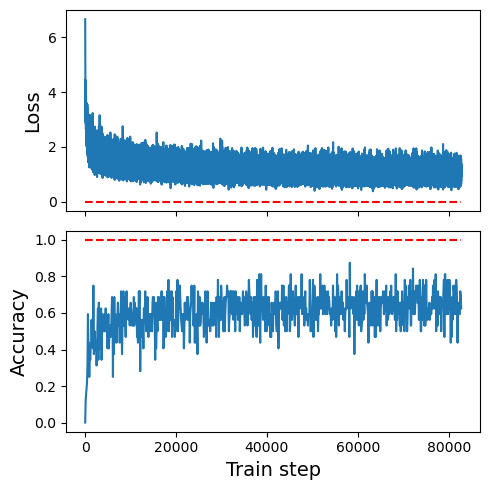

In [11]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

In [12]:
dataset.next_states.shape

torch.Size([16547, 23])

In [13]:
dataset.state_feature_names

['ra_cos',
 'ra_sin',
 'dec',
 'az_cos',
 'az_sin',
 'el',
 'airmass',
 'ha_cos',
 'ha_sin',
 'sun_ra_cos',
 'sun_ra_sin',
 'sun_dec',
 'sun_az_cos',
 'sun_az_sin',
 'sun_el',
 'moon_ra_cos',
 'moon_ra_sin',
 'moon_dec',
 'moon_az_cos',
 'moon_az_sin',
 'moon_el',
 'time_fraction_since_start',
 'time_seconds_till_end']

# Roll out policy

Actually, instead of getting the trajectory, here we're just giving all of the original schedule's states, and asking what action we should pick

In [15]:
with torch.no_grad():
    q_vals = agent.algorithm.policy_net(dataset.states.to(device))
    eval_actions = torch.argmax(q_vals, dim=1).detach().numpy()
    

# Plotting results

In [16]:
from survey_ops.utils.geometry import angular_separation


## First, visualize healpix's gridding and actual ra, dec of observed fields

In [17]:
ordered_bin_radec = np.array([dataset.binid2radec[i] for i in range(len(dataset.binid2radec))])
c = plt.scatter(ordered_bin_radec[:, 0], ordered_bin_radec[:, 1], c=np.arange(len(ordered_bin_radec)))
cbar = plt.colorbar(c)
cbar.set_label(label='bin ID')

obs_bin_radec = np.array([dataset.binid2radec[bin_idx] for bin_idx in dataset.actions.detach().numpy()])
plt.scatter(obs_bin_radec[:, 0], obs_bin_radec[:, 1], color='red', label='observed fields')
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()



AttributeError: 'OfflineDECamDataset' object has no attribute 'binid2radec'

In [19]:
# get index of the first observation for each night
first_obs_in_night_indices = []
for key, indices in dataset._df.groupby('night').indices.items():
    first_obs_in_night_indices.append(indices[0])

In [23]:
# Sequence of actions from target (original schedule) and policy
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions

# # Given the action (bin) chosen in the original schedule and in the policy's schedule
# # obtain the angular separation between the two bins for all actions
# target_radec = np.array([dataset.binid2radec[bin_id] for bin_id in target_sequence])
# eval_radec = np.array([dataset.binid2radec[bin_id] for bin_id in eval_sequence])
# # target_angsep = np.array([angular_separation(pos1=target_radec[i]*units.deg, pos2=target_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# # eval_angsep = np.array([angular_separation(pos1=eval_radec[i]*units.deg, pos2=eval_radec[i+1]*units.deg) for i in range(len(target_radec) - 1)]) / units.deg
# target_eval_angsep = np.array([angular_separation(eval_radec[i]*units.deg, pos2=target_radec[i]*units.deg) for i in range(len(target_radec))]) / units.deg

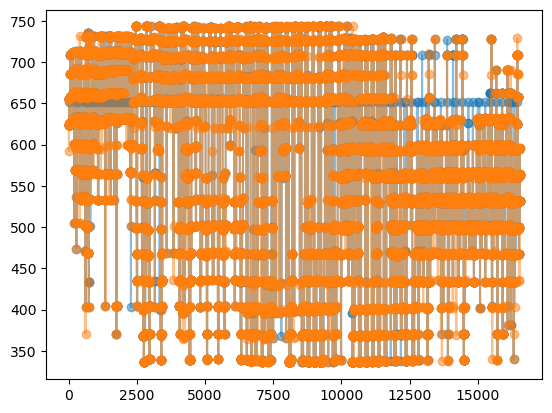

In [27]:
plt.plot(eval_sequence, marker='o', alpha=.5)
plt.plot(target_sequence, marker='o', alpha=.5)

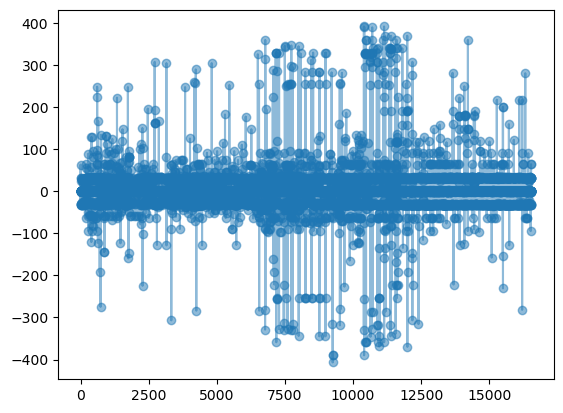

In [28]:
plt.plot(eval_sequence - target_sequence, marker='o', alpha=.5)


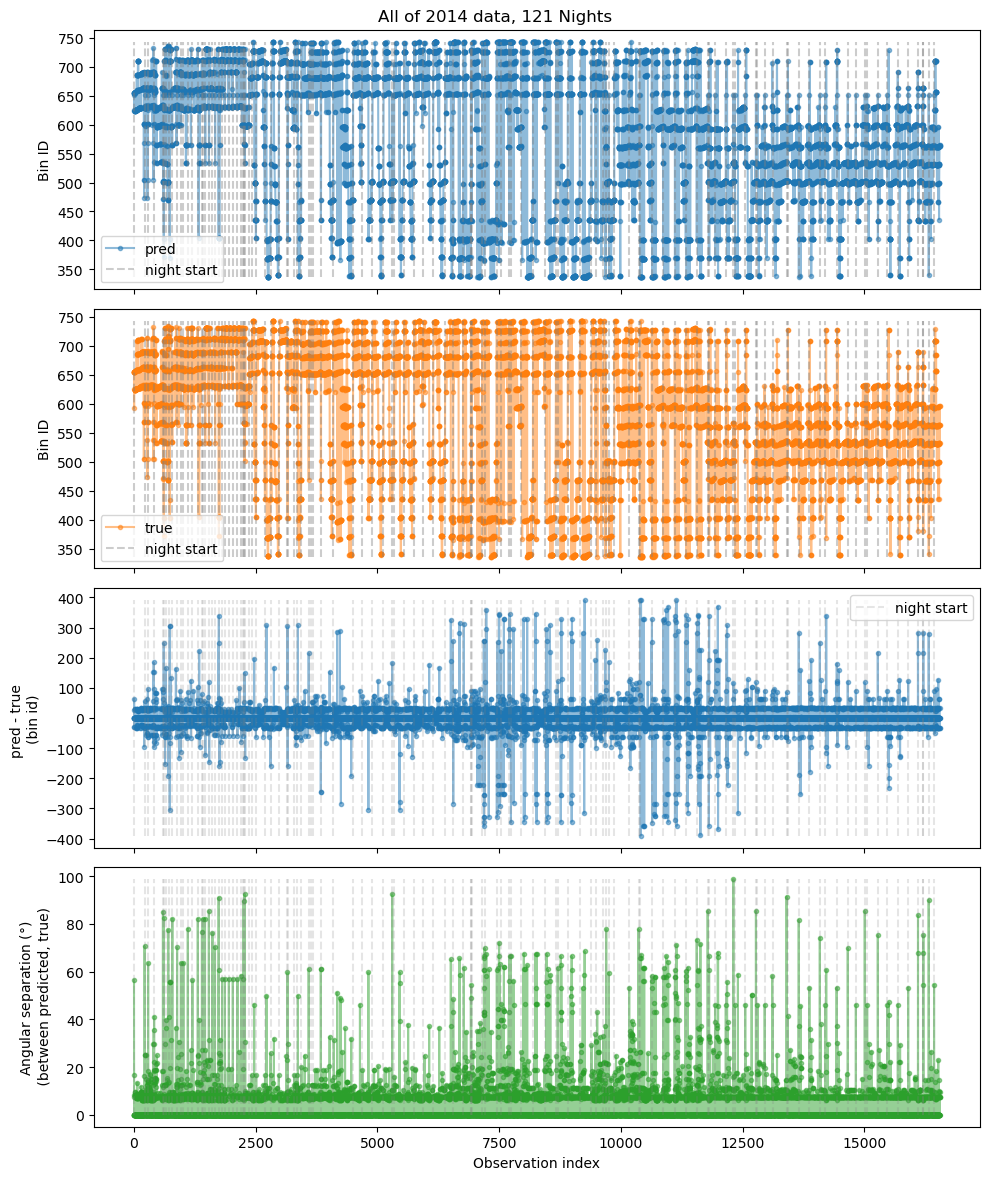

In [134]:
fig, axs = plt.subplots(4, figsize=(10,12), sharex=True)
axs[0].plot(eval_sequence, marker='o', label='pred', alpha=.5, markersize=3)
axs[0].vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence), ymax=np.max(eval_sequence), linestyle='--', color='grey', label='night start', alpha=.4)
axs[0].set_ylabel('Bin ID')
axs[0].legend()

axs[1].plot(target_sequence, marker='o', label='true', color='C1', alpha=.5, markersize=3)
axs[1].vlines(first_obs_in_night_indices, ymin=np.min(target_sequence), ymax=np.max(target_sequence), linestyle='--', color='grey', label='night start', alpha=.4)
axs[1].set_ylabel('Bin ID')
axs[1].legend()

axs[2].plot(eval_sequence - target_sequence, marker='o', alpha=.5, markersize=3)
axs[2].vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence - target_sequence), ymax=np.max(eval_sequence - target_sequence), linestyle='--', color='grey', label='night start', alpha=.2)
axs[2].legend()
axs[2].set_ylabel('pred - true \n(bin id)')

axs[3].plot(target_eval_angsep, marker='o', color='C2', alpha=.5, markersize=3)
axs[3].vlines(first_obs_in_night_indices, ymin=np.min(target_eval_angsep), ymax=np.max(target_eval_angsep), linestyle='--', color='grey', label='night start', alpha=.2)
axs[3].set_xlabel('Observation index')
axs[3].set_ylabel(r'Angular separation $(\degree)$' '\n (between predicted, true)')

fig.tight_layout()
fig.suptitle(f'All of 2014 data, {dataset.n_nights} Nights')
fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')